# Exploratory Data Analysis

I ran a basic EDA that (i) checks the distribution of some variables and performs variable transformations (log, square root and cubic root) in case of non-normal behaviors and (ii) explores the relationship between some variables and defaulting. Whether a credit holder defaults is captured by the feature `DEFAULT`, where 0 is a non-defaulter and 1 a defaulter. The notebook may take some time to run due to the plotting of some of the histograms. I summarize the main results below.

I provide some basic comments within some code cells to follow what the code does.

Note that `DEFAULT` is `default.payment.next.month` in the original dataset. I use `DEFAULT` for simplicity.

## Loading data and basic info

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from scipy import stats # This is used in a Box-Cox transformation
from sklearn import preprocessing

In [2]:
### The DataFrame is wide, so we'd like to be able to see all columns
pd.set_option('display.max_columns', None)

### Let's load the data into a DataFrame and check some basic info
creditCard = pd.read_csv("../UCI_Credit_Card.csv")
creditCard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [3]:
### Let's quickly check how the data looks like

creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
### We'll rename 'default.payment.next.month' to 'DEFAULT' for simplicity
creditCard.rename({"default.payment.next.month": "DEFAULT"}, axis = 1, inplace = True)

### We'll rename 'PAY_0' to 'PAY_1' to keep consistency in namings (see the description for 'BILL_AMT#' and 'PAY_AMT#'
### in kaggle)
    # https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset
creditCard.rename({"PAY_0": "PAY_1"}, axis = 1, inplace = True)
creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


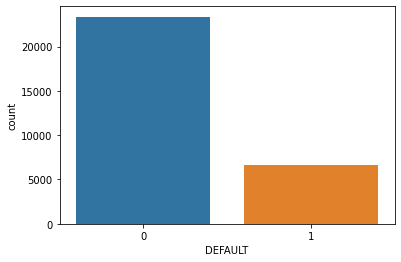

In [5]:
### We'll plot and count the defaulters and non-defaulters

sns.countplot(x = "DEFAULT", data = creditCard)
plt.show()

In [86]:
print("Proportion of defaulters: " + str(len(creditCard[creditCard["DEFAULT"] == 1])/len(creditCard)) + "\n" + \
     "Proportion of non-defaulters " + str(len(creditCard[creditCard["DEFAULT"] == 0])/len(creditCard)))

Proportion of defaulters: 0.2212
Proportion of non-defaulters 0.7788


## `LIMIT_BAL`

This continuous variable captures the credit amount. Its histogram shows non-normal behavior (a right-skewed distribution). A visual inspection of the transformations suggests the square root transformation is somewhat better than the other two.

A boxplot of `LIMIT_BAL` contrasting defaulters and non-defaulters suggests the credit amount might be an important feature to understand defaulting, where smaller credit amounts lead to more defaulting. A further analysis that discretizes the credit amount into several categories shows the probability of defaulting reduces as the credit amount increases.

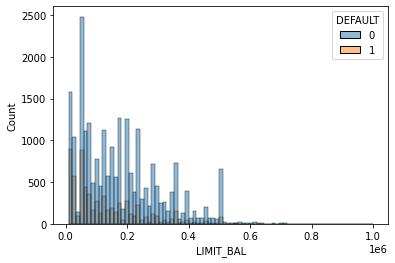

In [7]:
sns.histplot(x = "LIMIT_BAL", hue = "DEFAULT", data = creditCard)
plt.show()

In [87]:
### Let's check some basic stats

creditCard["LIMIT_BAL"].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

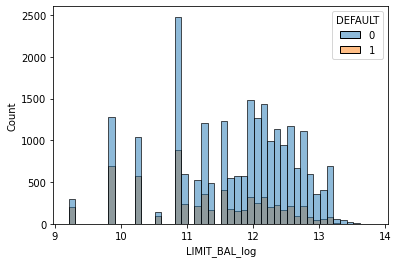

In [8]:
### Let's try a log-transformation of 'LIMIT_BAL'

creditCard["LIMIT_BAL_log"] = np.log(creditCard["LIMIT_BAL"])
sns.histplot(x = "LIMIT_BAL_log", hue = "DEFAULT", data = creditCard)
plt.show()

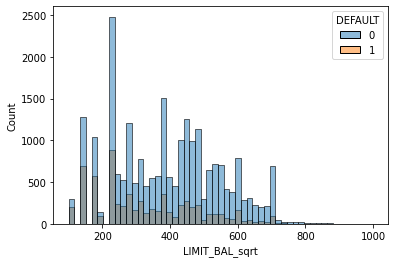

In [9]:
### Let's try a square root transformation of 'LIMIT_BAL'

creditCard["LIMIT_BAL_sqrt"] = np.sqrt(creditCard["LIMIT_BAL"])
sns.histplot(x = "LIMIT_BAL_sqrt", hue = "DEFAULT", data = creditCard)
plt.show()

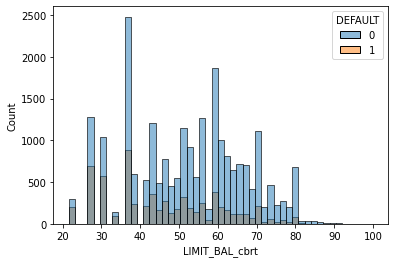

In [10]:
### Let's try a cubic root transformation of 'LIMIT_BAL'
    # https://www.statology.org/transform-data-in-python/

creditCard["LIMIT_BAL_cbrt"] = np.cbrt(creditCard["LIMIT_BAL"])
sns.histplot(x = "LIMIT_BAL_cbrt", hue = "DEFAULT", data = creditCard)
plt.show()

In [11]:
### Let's delete the transformations of 'LIMIT_BAL'

creditCard.drop("LIMIT_BAL_log", axis = 1, inplace = True)
#creditCard.drop("LIMIT_BAL_sqrt", axis = 1, inplace = True)
creditCard.drop("LIMIT_BAL_cbrt", axis = 1, inplace = True)

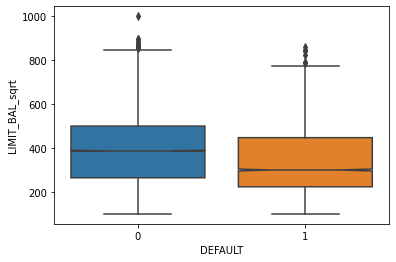

In [12]:
### Let's explore whether 'LIMIT_BAL' relates to defaulting

sns.boxplot(x = "DEFAULT", y = "LIMIT_BAL_sqrt", data = creditCard, notch = True)
plt.show()

In [13]:
### Let's discretize the credit amount to study the probability of defaulting as the credit amount gets bigger.
### The following code discretizes 'LIMIT_BAL' into 20 categories
    # https://pbpython.com/pandas-qcut-cut.html

results, bin_edges = pd.cut(creditCard["LIMIT_BAL"], bins = np.linspace(creditCard["LIMIT_BAL"].min(), \
    creditCard["LIMIT_BAL"].max(), 21), retbins = True, include_lowest = True, labels = None)

In [14]:
### For illustrative purposes, let's see the results, i.e., in what category each person falls into given her
### credit amount

results

0         (9999.999, 59500.0]
1        (109000.0, 158500.0]
2         (59500.0, 109000.0]
3         (9999.999, 59500.0]
4         (9999.999, 59500.0]
                 ...         
29995    (208000.0, 257500.0]
29996    (109000.0, 158500.0]
29997     (9999.999, 59500.0]
29998     (59500.0, 109000.0]
29999     (9999.999, 59500.0]
Name: LIMIT_BAL, Length: 30000, dtype: category
Categories (20, interval[float64]): [(9999.999, 59500.0] < (59500.0, 109000.0] < (109000.0, 158500.0] < (158500.0, 208000.0] ... (802000.0, 851500.0] < (851500.0, 901000.0] < (901000.0, 950500.0] < (950500.0, 1000000.0]]

In [15]:
bin_edges

array([  10000.,   59500.,  109000.,  158500.,  208000.,  257500.,
        307000.,  356500.,  406000.,  455500.,  505000.,  554500.,
        604000.,  653500.,  703000.,  752500.,  802000.,  851500.,
        901000.,  950500., 1000000.])

In [16]:
### Now let's do the discretization for real

### This code extracts only the bin edges, which we'll use later as the category labels
bin_edges = pd.cut(creditCard["LIMIT_BAL"], bins = np.linspace(creditCard["LIMIT_BAL"].min(), \
    creditCard["LIMIT_BAL"].max(), 21), retbins = True, include_lowest = True, labels = None)[1]

### We'll assign the labels extracted previously to the results of the discretization. Note that the argument
### 'retbins' is no longer used and the argument 'labels' takes the 'bin_edges' extracted above.
    ### I haven't found a way of doing this in one step
results = pd.cut(creditCard["LIMIT_BAL"], bins = np.linspace(creditCard["LIMIT_BAL"].min(), \
    creditCard["LIMIT_BAL"].max(), 21), include_lowest = True, labels = bin_edges.tolist()[1:21])

### We'll convert these results into a DataFrame and append them to the dataset
results = results.to_frame().rename(columns = {"LIMIT_BAL": "LIMIT_BAL_disc"})
creditCard = pd.concat([creditCard, results], axis = 1)

creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,LIMIT_BAL_disc
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,141.421356,59500.0
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,346.410162,158500.0
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,300.000000,109000.0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,223.606798,59500.0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,223.606798,59500.0


In [17]:
### Let's quickly check how people distribute across the 20 credit categories

creditCard["LIMIT_BAL_disc"].value_counts()

59500.0      7676
109000.0     4822
208000.0     3978
158500.0     3902
257500.0     2905
307000.0     2154
406000.0     1553
356500.0     1206
505000.0     1025
455500.0      573
554500.0       76
604000.0       51
653500.0       37
703000.0       19
752500.0       17
802000.0        5
1000000.0       1
950500.0        0
851500.0        0
901000.0        0
Name: LIMIT_BAL_disc, dtype: int64

In [18]:
### Since defaulters have DEFAULT = 1, a simple average over 'DEFAULT' will tell us the average probability of defaulting

# 1. We group by the credit categories and average 'DEFAULT' across each category
# 2. We reset the index to have a clean DataFrame
# 3. We rename 'DEFAULT' to 'DEFAULT_prob'
credit_bars = creditCard[["LIMIT_BAL_disc", "DEFAULT"]].groupby("LIMIT_BAL_disc").mean()
credit_bars.reset_index(inplace = True)
credit_bars.rename(columns = {"DEFAULT": "DEFAULT_prob"}, inplace = True)

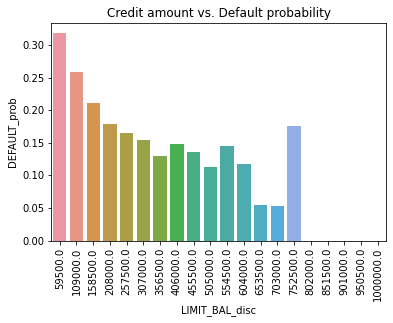

In [19]:
### Let's visually check the probability of defaulting as the credit amount gets bigger

sns.barplot(x = "LIMIT_BAL_disc", y = "DEFAULT_prob", data = credit_bars)
plt.title("Credit amount vs. Default probability")
plt.xticks(rotation = 90)
plt.show()

In [20]:
### Let's delete the discretized 'LIMIT_BAL'

#creditCard.drop("LIMIT_BAL_disc", axis = 1, inplace = True)
#creditCard.head()

## `BILL_AMT#`

These continuous variables capture the amounts to be paid shown in bill statements. They're available for six months, where `BILL_AMT1` captures the amount to be paid in the Sep statement, `BILL_AMT2` captures the amount to be paid in the Aug statement, and so on up to `BILL_AMT6` (Apr).

Their histograms show non-normal behaviors (right-skewed distributions) and negative values. These values are positive balances for the credit holder. A visual inspection of the transformations suggests the cubic root transformation is better than the other two.

Boxplots of `BILL_AMT#` contrasting defaulters and non-defaulters suggest the amounts to be paid shown in bill statements might not be important features to understand defaulting.

A correlation analysis shows strong correlations among the `BILL_AMT#` features. This suggests we could only use one of them in the modeling work. The last amount to be paid (Sep) seems a straightforward choice. A further analysis that discretizes this amount into several categories shows the probability of defaulting:

- is null for negative bill amounts (these represent positive balances for the credit holder);
- remains fairly constant (at around 20%) for bill amounts up to 455,970;
- shows two jumps: one for bill amounts up to 512,474 (with defaulting at around 30%) and another one for bill amounts up to 625,483 (with defaulting at around 40%);
- and comes back to 0 for bill amounts greater than 625,483.

Contrary to the visual inspection of boxplots mentioned above, this last analysis suggests it might be worthwhile to look at the amount to be paid in the last available statement to understand defaulting.

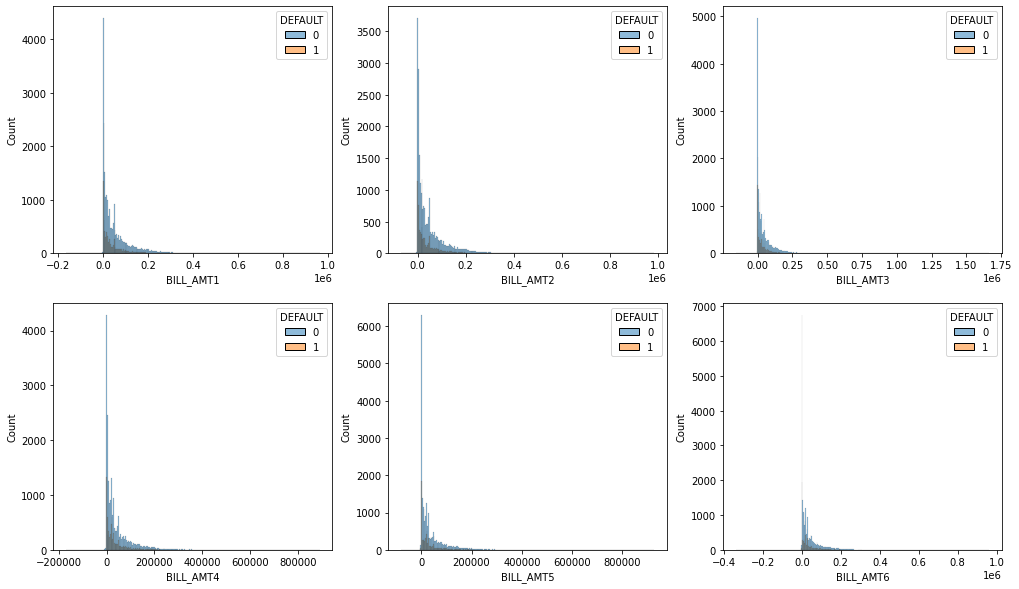

In [21]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.histplot(x = "BILL_AMT1", hue = "DEFAULT", data = creditCard, ax = ax[0, 0])
sns.histplot(x = "BILL_AMT2", hue = "DEFAULT", data = creditCard, ax = ax[0, 1])
sns.histplot(x = "BILL_AMT3", hue = "DEFAULT", data = creditCard, ax = ax[0, 2])
sns.histplot(x = "BILL_AMT4", hue = "DEFAULT", data = creditCard, ax = ax[1, 0])
sns.histplot(x = "BILL_AMT5", hue = "DEFAULT", data = creditCard, ax = ax[1, 1])
sns.histplot(x = "BILL_AMT6", hue = "DEFAULT", data = creditCard, ax = ax[1, 2])
plt.show()

In [22]:
### Let's check some basic stats

cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
creditCard[cols].describe()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
count,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000
mean,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400
std,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537
min,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000
25%,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000
50%,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000
75%,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000
max,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000


In [23]:
### Let's try a log-transformation of 'BILL_AMT#'

cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
for col in cols:
    name = col + "_log"
    creditCard[name] = np.log(creditCard[col] + abs(creditCard[col].min()) + 0.001)
creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,LIMIT_BAL_disc,BILL_AMT1_log,BILL_AMT2_log,BILL_AMT3_log,BILL_AMT4_log,BILL_AMT5_log,BILL_AMT6_log
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,141.421356,59500.0,12.040567,11.196556,11.970053,12.043554,11.306319,12.735533
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,346.410162,158500.0,12.033278,11.177481,11.982592,12.062618,11.347921,12.745089
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,300.000000,109000.0,12.179826,11.336236,12.048383,12.124488,11.475037,12.780301
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,223.606798,59500.0,12.267027,11.678525,12.238322,12.197607,11.610896,12.818958
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,223.606798,59500.0,12.067942,11.231186,12.170958,12.159715,11.517714,12.790336


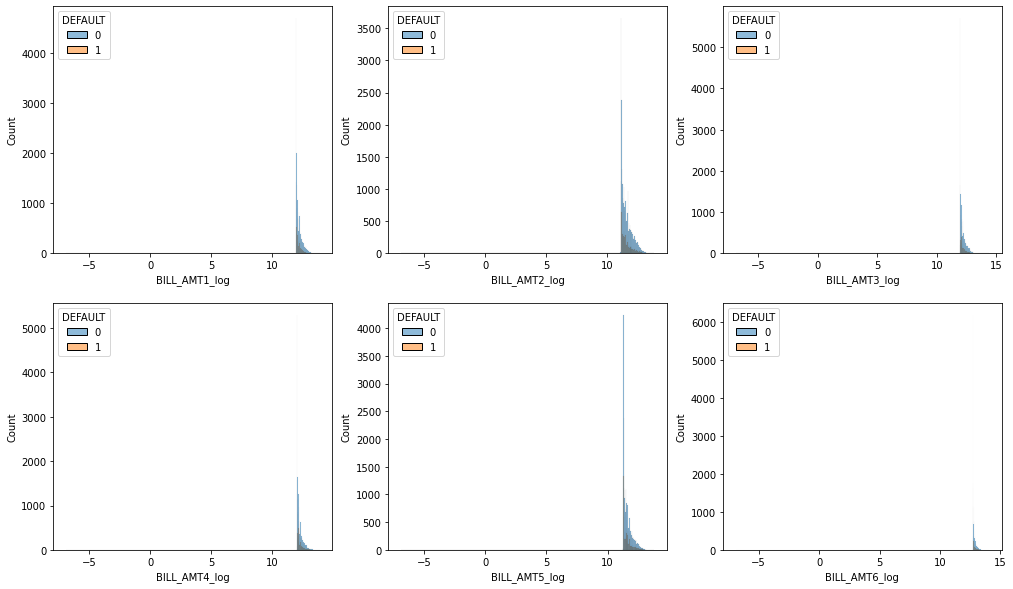

In [24]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.histplot(x = "BILL_AMT1_log", hue = "DEFAULT", data = creditCard, ax = ax[0, 0])
sns.histplot(x = "BILL_AMT2_log", hue = "DEFAULT", data = creditCard, ax = ax[0, 1])
sns.histplot(x = "BILL_AMT3_log", hue = "DEFAULT", data = creditCard, ax = ax[0, 2])
sns.histplot(x = "BILL_AMT4_log", hue = "DEFAULT", data = creditCard, ax = ax[1, 0])
sns.histplot(x = "BILL_AMT5_log", hue = "DEFAULT", data = creditCard, ax = ax[1, 1])
sns.histplot(x = "BILL_AMT6_log", hue = "DEFAULT", data = creditCard, ax = ax[1, 2])
plt.show()

In [25]:
### Let's delete the log-transformations of 'BILL_AMT#'

cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
for col in cols:
    name = col + "_log"
    creditCard.drop(name, axis = 1, inplace = True)

In [26]:
### Let's try a Box-Cox transformation of 'BILL_AMT#'

"""cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
for col in cols:
    name = col + "_bc"
    creditCard[name] = stats.boxcox(creditCard[col] + abs(creditCard[col].min()) + 0.001)[0]
creditCard.head()"""

'cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]\nfor col in cols:\n    name = col + "_bc"\n    creditCard[name] = stats.boxcox(creditCard[col] + abs(creditCard[col].min()) + 0.001)[0]\ncreditCard.head()'

In [27]:
"""fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.histplot(x = "BILL_AMT1_bc", hue = "DEFAULT", data = creditCard, ax = ax[0, 0])
sns.histplot(x = "BILL_AMT2_bc", hue = "DEFAULT", data = creditCard, ax = ax[0, 1])
sns.histplot(x = "BILL_AMT3_bc", hue = "DEFAULT", data = creditCard, ax = ax[0, 2])
sns.histplot(x = "BILL_AMT4_bc", hue = "DEFAULT", data = creditCard, ax = ax[1, 0])
sns.histplot(x = "BILL_AMT5_bc", hue = "DEFAULT", data = creditCard, ax = ax[1, 1])
sns.histplot(x = "BILL_AMT6_bc", hue = "DEFAULT", data = creditCard, ax = ax[1, 2])
plt.show()"""

'fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))\nsns.histplot(x = "BILL_AMT1_bc", hue = "DEFAULT", data = creditCard, ax = ax[0, 0])\nsns.histplot(x = "BILL_AMT2_bc", hue = "DEFAULT", data = creditCard, ax = ax[0, 1])\nsns.histplot(x = "BILL_AMT3_bc", hue = "DEFAULT", data = creditCard, ax = ax[0, 2])\nsns.histplot(x = "BILL_AMT4_bc", hue = "DEFAULT", data = creditCard, ax = ax[1, 0])\nsns.histplot(x = "BILL_AMT5_bc", hue = "DEFAULT", data = creditCard, ax = ax[1, 1])\nsns.histplot(x = "BILL_AMT6_bc", hue = "DEFAULT", data = creditCard, ax = ax[1, 2])\nplt.show()'

In [28]:
### Let's delete the Box-Cox transformations of 'BILL_AMT#'

"""cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
for col in cols:
    name = col + "_bc"
    creditCard.drop(name, axis = 1, inplace = True)"""

'cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]\nfor col in cols:\n    name = col + "_bc"\n    creditCard.drop(name, axis = 1, inplace = True)'

In [29]:
### Let's try a square root transformation of 'BILL_AMT#'

cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
for col in cols:
    name = col + "_sqrt"
    creditCard[name] = np.sqrt(creditCard[col] + abs(creditCard[col].min()) + 0.001)
creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,LIMIT_BAL_disc,BILL_AMT1_sqrt,BILL_AMT2_sqrt,BILL_AMT3_sqrt,BILL_AMT4_sqrt,BILL_AMT5_sqrt,BILL_AMT6_sqrt
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,141.421356,59500.0,411.695277,269.961110,397.433014,412.310564,285.191166,582.754666
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,346.410162,158500.0,410.197515,267.398581,399.932496,416.259536,291.185510,585.545900
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,300.000000,109000.0,441.383055,289.489207,413.307393,429.337863,310.293411,595.946307
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,223.606798,59500.0,461.053143,343.525837,454.483224,445.324602,332.103901,607.577156
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,223.606798,59500.0,417.369142,274.676175,439.430314,436.966819,316.985806,598.944072


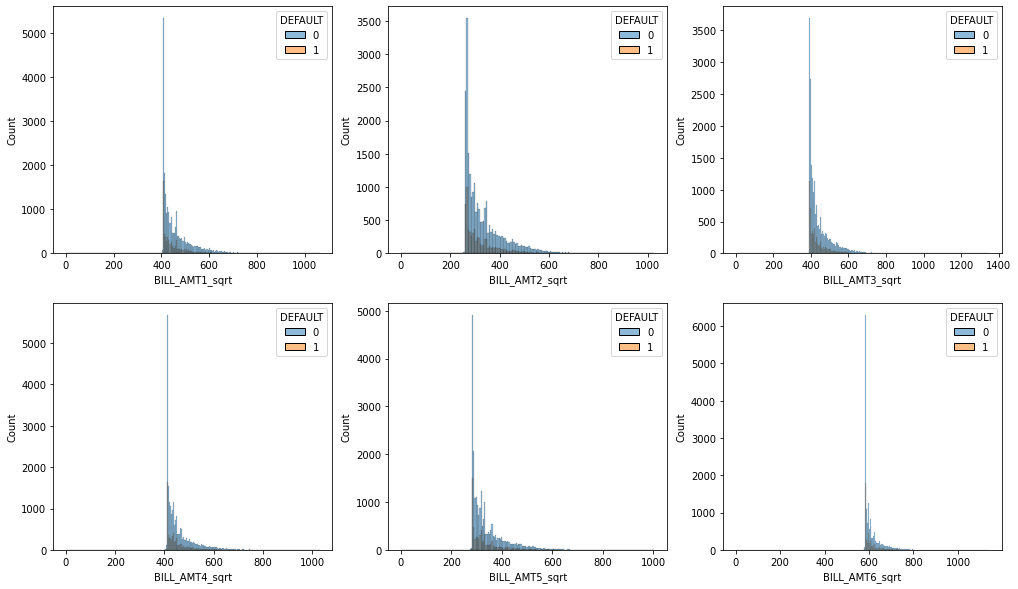

In [30]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.histplot(x = "BILL_AMT1_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[0, 0])
sns.histplot(x = "BILL_AMT2_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[0, 1])
sns.histplot(x = "BILL_AMT3_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[0, 2])
sns.histplot(x = "BILL_AMT4_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[1, 0])
sns.histplot(x = "BILL_AMT5_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[1, 1])
sns.histplot(x = "BILL_AMT6_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[1, 2])
plt.show()

In [31]:
### Let's delete the sqrt-transformations of 'BILL_AMT#'

cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
for col in cols:
    name = col + "_sqrt"
    creditCard.drop(name, axis = 1, inplace = True)

In [32]:
### Let's try a cubic root transformation of 'BILL_AMT#'

cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
for col in cols:
    name = col + "_cbrt"
    creditCard[name] = np.cbrt(creditCard[col])
creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,LIMIT_BAL_disc,BILL_AMT1_cbrt,BILL_AMT2_cbrt,BILL_AMT3_cbrt,BILL_AMT4_cbrt,BILL_AMT5_cbrt,BILL_AMT6_cbrt
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,141.421356,59500.0,15.758079,14.584132,8.832285,0.000000,0.000000,0.000000
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,346.410162,158500.0,13.893754,11.993052,13.893754,14.845828,15.117594,14.829173
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,300.000000,109000.0,30.807338,24.116906,23.845653,24.289887,24.633589,24.959401
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,223.606798,59500.0,36.085701,36.401121,36.665353,30.478979,30.708683,30.915134
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,223.606798,59500.0,20.501487,17.831766,32.968749,27.562941,26.752191,26.745203


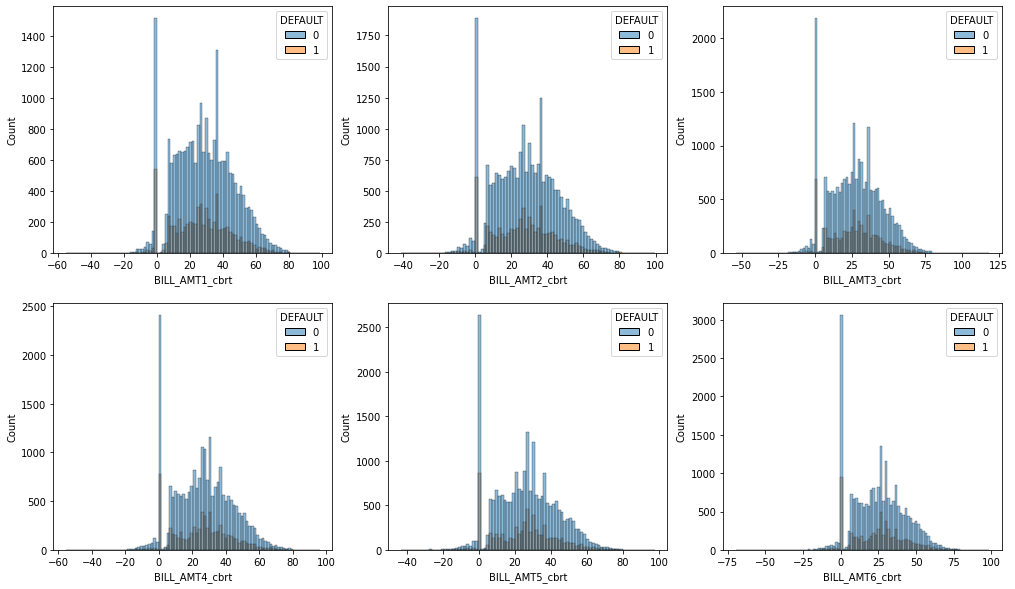

In [33]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.histplot(x = "BILL_AMT1_cbrt", hue = "DEFAULT", data = creditCard, ax = ax[0, 0])
sns.histplot(x = "BILL_AMT2_cbrt", hue = "DEFAULT", data = creditCard, ax = ax[0, 1])
sns.histplot(x = "BILL_AMT3_cbrt", hue = "DEFAULT", data = creditCard, ax = ax[0, 2])
sns.histplot(x = "BILL_AMT4_cbrt", hue = "DEFAULT", data = creditCard, ax = ax[1, 0])
sns.histplot(x = "BILL_AMT5_cbrt", hue = "DEFAULT", data = creditCard, ax = ax[1, 1])
sns.histplot(x = "BILL_AMT6_cbrt", hue = "DEFAULT", data = creditCard, ax = ax[1, 2])
plt.show()

In [34]:
### Let's delete the cbrt-transformations of 'BILL_AMT#'

"""cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]
for col in cols:
    name = col + "_cbrt"
    creditCard.drop(name, axis = 1, inplace = True)"""

'cols = ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]\nfor col in cols:\n    name = col + "_cbrt"\n    creditCard.drop(name, axis = 1, inplace = True)'

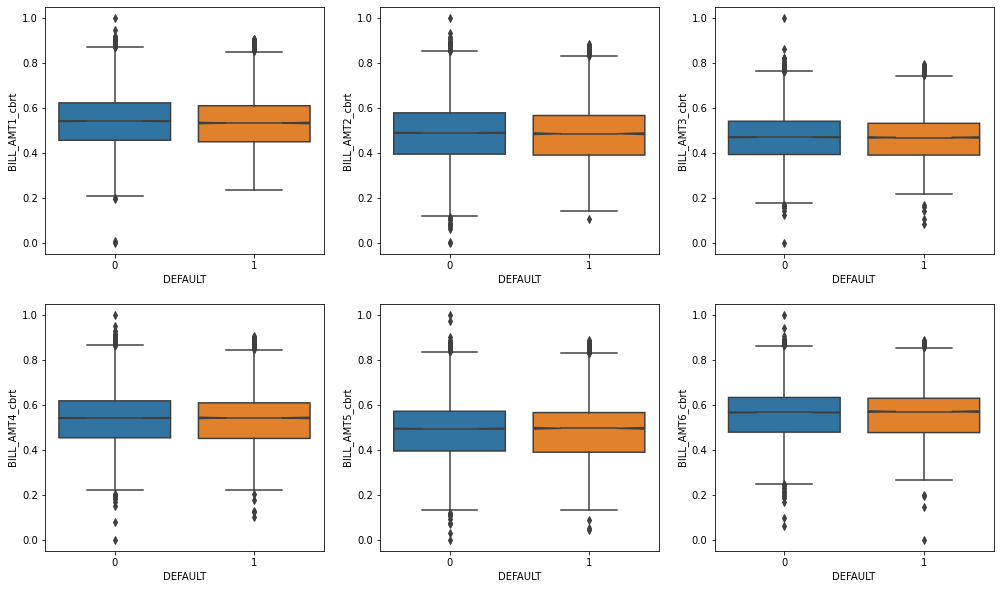

In [35]:
### Let's explore whether 'BILL_AMT#' relates to defaulting

# We extract the relevant columns to scale them so that it's visually easier to see the relationships
cols = ["BILL_AMT1_cbrt", "BILL_AMT2_cbrt", "BILL_AMT3_cbrt", "BILL_AMT4_cbrt", "BILL_AMT5_cbrt", "BILL_AMT6_cbrt"]
creditCard_bills = creditCard[cols].copy()

# We apply the min-max scaler
scaler = preprocessing.MinMaxScaler()
creditCard_bills[cols] = scaler.fit_transform(creditCard_bills[cols])

# We concatenate the scaled features with 'DEFAULT'
creditCard_bills = pd.concat([creditCard_bills, creditCard[["DEFAULT"]]], axis = 1)

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.boxplot(x = "DEFAULT", y = "BILL_AMT1_cbrt", data = creditCard_bills, ax = ax[0, 0], notch = True)
sns.boxplot(x = "DEFAULT", y = "BILL_AMT2_cbrt", data = creditCard_bills, ax = ax[0, 1], notch = True)
sns.boxplot(x = "DEFAULT", y = "BILL_AMT3_cbrt", data = creditCard_bills, ax = ax[0, 2], notch = True)
sns.boxplot(x = "DEFAULT", y = "BILL_AMT4_cbrt", data = creditCard_bills, ax = ax[1, 0], notch = True)
sns.boxplot(x = "DEFAULT", y = "BILL_AMT5_cbrt", data = creditCard_bills, ax = ax[1, 1], notch = True)
sns.boxplot(x = "DEFAULT", y = "BILL_AMT6_cbrt", data = creditCard_bills, ax = ax[1, 2], notch = True)
plt.show()

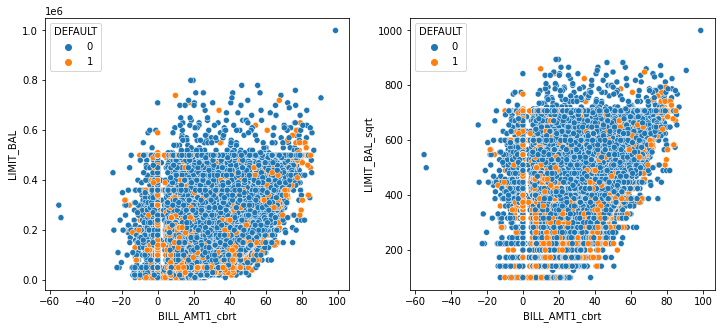

In [36]:
### We could also explore how the bill amounts relate to the credit amount and differentiate defaulters
### from non-defaulters. For illustrative purposes, we only plot the scatterplots for 'BILL_AMT1' 

# Overall, defaulters seem to concentrate more in the lower half (lower credit amounts) and perhaps also in the
# upper right (higher credit amounts and higher last bill amounts)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.scatterplot(x = "BILL_AMT1_cbrt", y = "LIMIT_BAL", hue = "DEFAULT", data = creditCard, ax = ax[0])
sns.scatterplot(x = "BILL_AMT1_cbrt", y = "LIMIT_BAL_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[1])
plt.show()

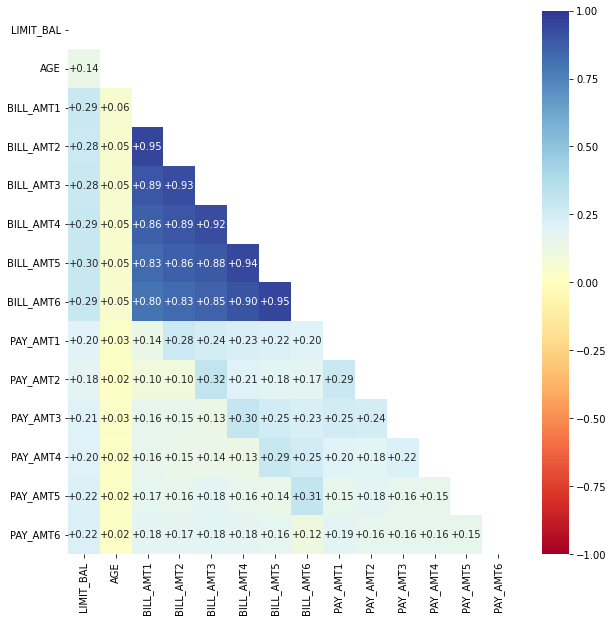

In [37]:
### Let's do a correlation analysis for the quantitative features

creditCardCorrM = creditCard[["LIMIT_BAL", "AGE", "BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", \
    "BILL_AMT6", "PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]].corr()

# Mask the upper half for visualization purposes
mask = np.zeros_like(creditCardCorrM, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (10, 10))
sns.heatmap(creditCardCorrM, mask = mask, cmap = "RdYlBu",
            vmin = -1, vmax = 1, annot = True,
            fmt = "+.2f")
plt.show()

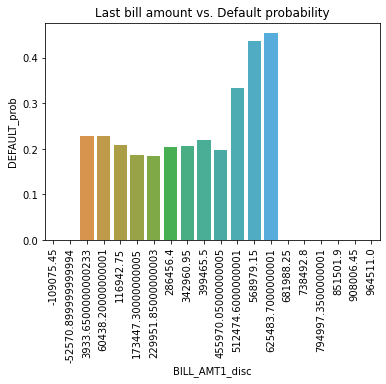

In [38]:
### Let's discretize 'BILL_AMT1' to study the probability of defaulting as the last bill amount gets bigger

results, bin_edges = pd.cut(creditCard["BILL_AMT1"], bins = np.linspace(creditCard["BILL_AMT1"].min(), \
    creditCard["BILL_AMT1"].max(), 21), retbins = True, include_lowest = True, labels = None)

### This code extracts only the bin edges, which we'll use later as the category labels
bin_edges = pd.cut(creditCard["BILL_AMT1"], bins = np.linspace(creditCard["BILL_AMT1"].min(), \
    creditCard["BILL_AMT1"].max(), 21), retbins = True, include_lowest = True, labels = None)[1]

### We'll assign the labels extracted previously to the results of the discretization. Note that the argument
### 'retbins' is no longer used and the argument 'labels' takes the 'bin_edges' extracted above
results = pd.cut(creditCard["BILL_AMT1"], bins = np.linspace(creditCard["BILL_AMT1"].min(), \
    creditCard["BILL_AMT1"].max(), 21), include_lowest = True, labels = bin_edges.tolist()[1:21])

### We'll convert these results into a DataFrame and append them to the dataset
results = results.to_frame().rename(columns = {"BILL_AMT1": "BILL_AMT1_disc"})
creditCard = pd.concat([creditCard, results], axis = 1)

### Since defaulters have DEFAULT = 1, a simple average over 'DEFAULT' will tell us the average probability of defaulting
bill_amt1_bars = creditCard[["BILL_AMT1_disc", "DEFAULT"]].groupby("BILL_AMT1_disc").mean().reset_index().\
    rename(columns = {"DEFAULT": "DEFAULT_prob"})

### Let's visually check the probability of defaulting as the last bill amount gets bigger
sns.barplot(x = "BILL_AMT1_disc", y = "DEFAULT_prob", data = bill_amt1_bars)
plt.title("Last bill amount vs. Default probability")
plt.xticks(rotation = 90)
plt.show()

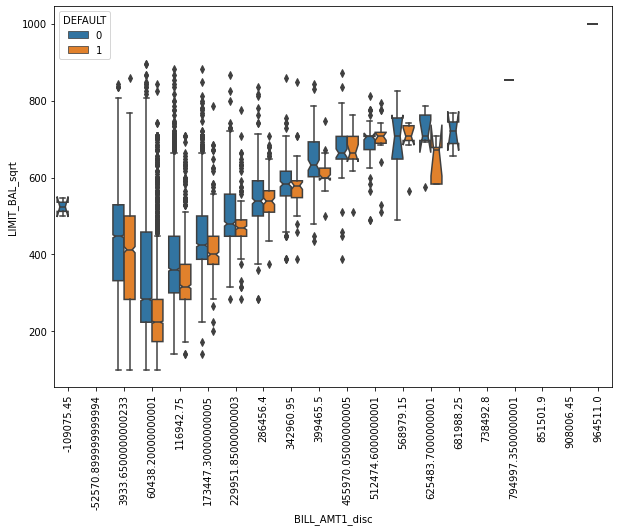

In [39]:
### We could also check how defaulting changes according to the credit amount and each last bill category

# The plot isn't clear-cut, but it seems to suggest defaulters have lower credit amounts overall

plt.figure(figsize = (10, 7))
sns.boxplot(x = "BILL_AMT1_disc", y = "LIMIT_BAL_sqrt", hue = "DEFAULT", data = creditCard, notch = True)
plt.xticks(rotation = 90)
plt.show()

In [40]:
### Let's delete the discretized 'BILL_AMT1'

#creditCard.drop("BILL_AMT1_disc", axis = 1, inplace = True)
#creditCard.head()

## `PAY_AMT#`

These continuous variables capture the paid amounts. They're available for six months, where `PAY_AMT1` captures the amount paid in Sep, `PAY_AMT2` captures the amount paid in Aug, and so on up to `PAY_AMT6` (Apr).

Their histograms show non-normal behaviors (right-skewed distributions). A visual inspection of the transformations suggests the log transformation is better than the other two.

Boxplots of `PAY_AMT#` contrasting defaulters and non-defaulters suggest the paid amounts might be important features to understand defaulting.

A correlation analysis shows some mild correlations among some of the `PAY_AMT#` features. Similar to the analysis ran for `BILL_AMT#`, we'll discretize the last payment made (Sep) into several categories. This analysis shows the probability of defaulting:

- is around 20% for small payments (up to 43,677);
- except for two bands, remains fairly constant (at about 10%) for values up to 305,743;
- and becomes 0% for values greater than 305,743.

This last analysis reinforces that it might be worthwhile to look at  the paid amounts to understand defaulting.

A quick inspection of several records suggests `PAY_AMT1` is the payment made for the Aug bill or `BILL_AMT2`, `PAY_AMT2` is the payment made for the Jul bill or `BILL_AMT3`, and so on. A correlation analysis suggests these variables are redundant since they're strongly correlated with `BILL_AMT1`.

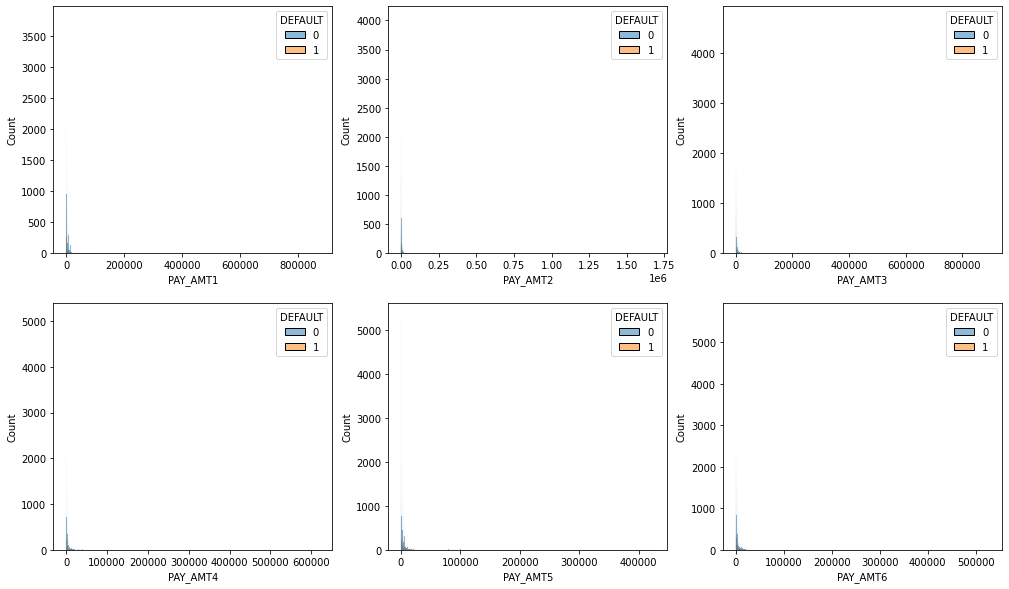

In [41]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.histplot(x = "PAY_AMT1", hue = "DEFAULT", data = creditCard, ax = ax[0, 0])
sns.histplot(x = "PAY_AMT2", hue = "DEFAULT", data = creditCard, ax = ax[0, 1])
sns.histplot(x = "PAY_AMT3", hue = "DEFAULT", data = creditCard, ax = ax[0, 2])
sns.histplot(x = "PAY_AMT4", hue = "DEFAULT", data = creditCard, ax = ax[1, 0])
sns.histplot(x = "PAY_AMT5", hue = "DEFAULT", data = creditCard, ax = ax[1, 1])
sns.histplot(x = "PAY_AMT6", hue = "DEFAULT", data = creditCard, ax = ax[1, 2])
plt.show()

In [42]:
### Let's check some basic stats

cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
creditCard[cols].describe()

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [43]:
### Let's try a log-transformation of 'PAY_AMT#'

cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
for col in cols:
    name = col + "_log"
    creditCard[name] = np.log(creditCard[col] + abs(creditCard[col].min()) + 0.001)
creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,LIMIT_BAL_disc,BILL_AMT1_cbrt,BILL_AMT2_cbrt,BILL_AMT3_cbrt,BILL_AMT4_cbrt,BILL_AMT5_cbrt,BILL_AMT6_cbrt,BILL_AMT1_disc,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,141.421356,59500.0,15.758079,14.584132,8.832285,0.000000,0.000000,0.000000,3933.65,-6.907755,6.535243,-6.907755,-6.907755,-6.907755,-6.907755
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,346.410162,158500.0,13.893754,11.993052,13.893754,14.845828,15.117594,14.829173,3933.65,-6.907755,6.907756,6.907756,6.907756,-6.907755,7.600903
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,300.000000,109000.0,30.807338,24.116906,23.845653,24.289887,24.633589,24.959401,60438.20,7.325150,7.313221,6.907756,6.907756,6.907756,8.517193
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,223.606798,59500.0,36.085701,36.401121,36.665353,30.478979,30.708683,30.915134,60438.20,7.600903,7.610358,7.090078,7.003066,6.974480,6.907756
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,223.606798,59500.0,20.501487,17.831766,32.968749,27.562941,26.752191,26.745203,60438.20,7.600903,10.510014,9.210340,9.104980,6.535243,6.520623


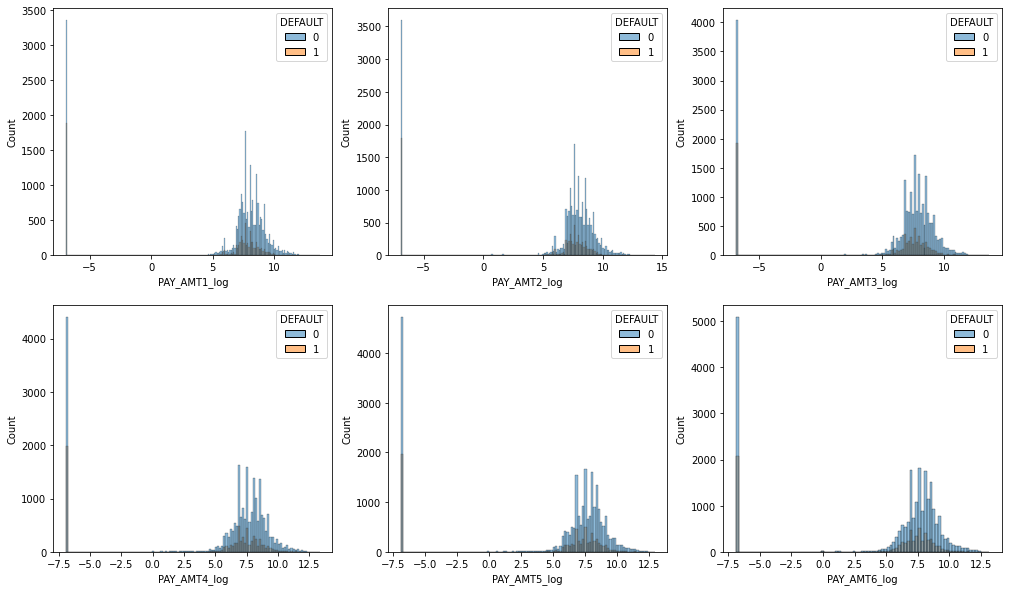

In [44]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.histplot(x = "PAY_AMT1_log", hue = "DEFAULT", data = creditCard, ax = ax[0, 0])
sns.histplot(x = "PAY_AMT2_log", hue = "DEFAULT", data = creditCard, ax = ax[0, 1])
sns.histplot(x = "PAY_AMT3_log", hue = "DEFAULT", data = creditCard, ax = ax[0, 2])
sns.histplot(x = "PAY_AMT4_log", hue = "DEFAULT", data = creditCard, ax = ax[1, 0])
sns.histplot(x = "PAY_AMT5_log", hue = "DEFAULT", data = creditCard, ax = ax[1, 1])
sns.histplot(x = "PAY_AMT6_log", hue = "DEFAULT", data = creditCard, ax = ax[1, 2])
plt.show()

In [45]:
### Let's delete the log-transformations of 'PAY_AMT#'

"""cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
for col in cols:
    name = col + "_log"
    creditCard.drop(name, axis = 1, inplace = True)"""

'cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]\nfor col in cols:\n    name = col + "_log"\n    creditCard.drop(name, axis = 1, inplace = True)'

In [46]:
### Let's try a square root transformation of 'PAY_AMT#'

cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
for col in cols:
    name = col + "_sqrt"
    creditCard[name] = np.sqrt(creditCard[col])
creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,LIMIT_BAL_disc,BILL_AMT1_cbrt,BILL_AMT2_cbrt,BILL_AMT3_cbrt,BILL_AMT4_cbrt,BILL_AMT5_cbrt,BILL_AMT6_cbrt,BILL_AMT1_disc,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log,PAY_AMT1_sqrt,PAY_AMT2_sqrt,PAY_AMT3_sqrt,PAY_AMT4_sqrt,PAY_AMT5_sqrt,PAY_AMT6_sqrt
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,141.421356,59500.0,15.758079,14.584132,8.832285,0.000000,0.000000,0.000000,3933.65,-6.907755,6.535243,-6.907755,-6.907755,-6.907755,-6.907755,0.000000,26.248809,0.000000,0.000000,0.000000,0.000000
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,346.410162,158500.0,13.893754,11.993052,13.893754,14.845828,15.117594,14.829173,3933.65,-6.907755,6.907756,6.907756,6.907756,-6.907755,7.600903,0.000000,31.622777,31.622777,31.622777,0.000000,44.721360
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,300.000000,109000.0,30.807338,24.116906,23.845653,24.289887,24.633589,24.959401,60438.20,7.325150,7.313221,6.907756,6.907756,6.907756,8.517193,38.961519,38.729833,31.622777,31.622777,31.622777,70.710678
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,223.606798,59500.0,36.085701,36.401121,36.665353,30.478979,30.708683,30.915134,60438.20,7.600903,7.610358,7.090078,7.003066,6.974480,6.907756,44.721360,44.933284,34.641016,33.166248,32.695565,31.622777
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,223.606798,59500.0,20.501487,17.831766,32.968749,27.562941,26.752191,26.745203,60438.20,7.600903,10.510014,9.210340,9.104980,6.535243,6.520623,44.721360,191.522845,100.000000,94.868330,26.248809,26.057628


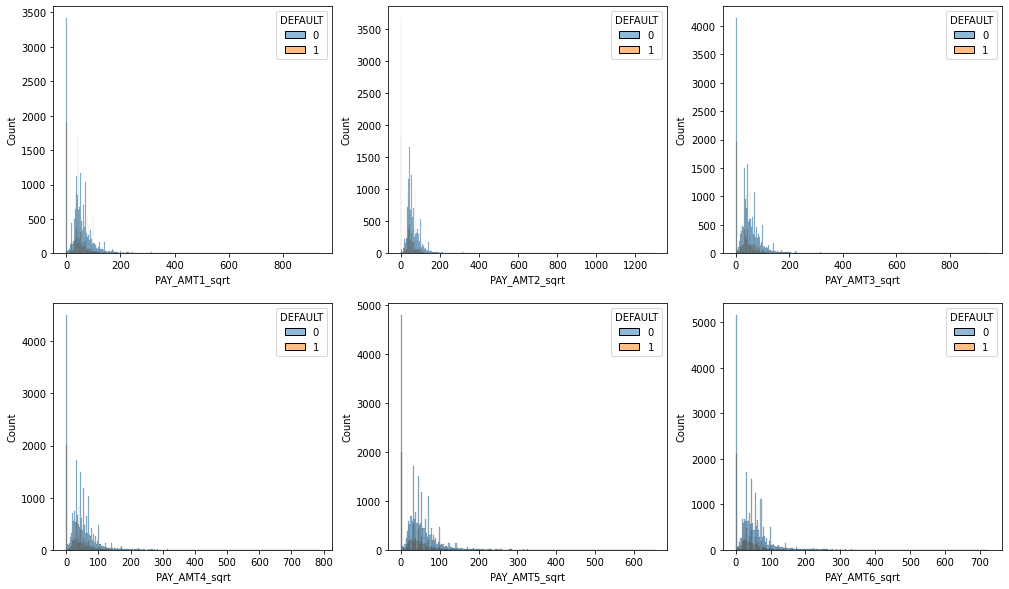

In [47]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.histplot(x = "PAY_AMT1_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[0, 0])
sns.histplot(x = "PAY_AMT2_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[0, 1])
sns.histplot(x = "PAY_AMT3_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[0, 2])
sns.histplot(x = "PAY_AMT4_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[1, 0])
sns.histplot(x = "PAY_AMT5_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[1, 1])
sns.histplot(x = "PAY_AMT6_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[1, 2])
plt.show()

In [48]:
### Let's delete the sqrt-transformations of 'PAY_AMT#'

cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
for col in cols:
    name = col + "_sqrt"
    creditCard.drop(name, axis = 1, inplace = True)

In [49]:
### Let's try a cubic root transformation of 'PAY_AMT#'

cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
for col in cols:
    name = col + "_cbrt"
    creditCard[name] = np.cbrt(creditCard[col])
creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,LIMIT_BAL_disc,BILL_AMT1_cbrt,BILL_AMT2_cbrt,BILL_AMT3_cbrt,BILL_AMT4_cbrt,BILL_AMT5_cbrt,BILL_AMT6_cbrt,BILL_AMT1_disc,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log,PAY_AMT1_cbrt,PAY_AMT2_cbrt,PAY_AMT3_cbrt,PAY_AMT4_cbrt,PAY_AMT5_cbrt,PAY_AMT6_cbrt
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,141.421356,59500.0,15.758079,14.584132,8.832285,0.000000,0.000000,0.000000,3933.65,-6.907755,6.535243,-6.907755,-6.907755,-6.907755,-6.907755,0.000000,8.832285,0.000000,0.000000,0.000000,0.000000
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,346.410162,158500.0,13.893754,11.993052,13.893754,14.845828,15.117594,14.829173,3933.65,-6.907755,6.907756,6.907756,6.907756,-6.907755,7.600903,0.000000,10.000000,10.000000,10.000000,0.000000,12.599210
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,300.000000,109000.0,30.807338,24.116906,23.845653,24.289887,24.633589,24.959401,60438.20,7.325150,7.313221,6.907756,6.907756,6.907756,8.517193,11.492749,11.447142,10.000000,10.000000,10.000000,17.099759
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,223.606798,59500.0,36.085701,36.401121,36.665353,30.478979,30.708683,30.915134,60438.20,7.600903,7.610358,7.090078,7.003066,6.974480,6.907756,12.599210,12.638982,10.626586,10.322801,10.224904,10.000000
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,223.606798,59500.0,20.501487,17.831766,32.968749,27.562941,26.752191,26.745203,60438.20,7.600903,10.510014,9.210340,9.104980,6.535243,6.520623,12.599210,33.226178,21.544347,20.800838,8.832285,8.789347


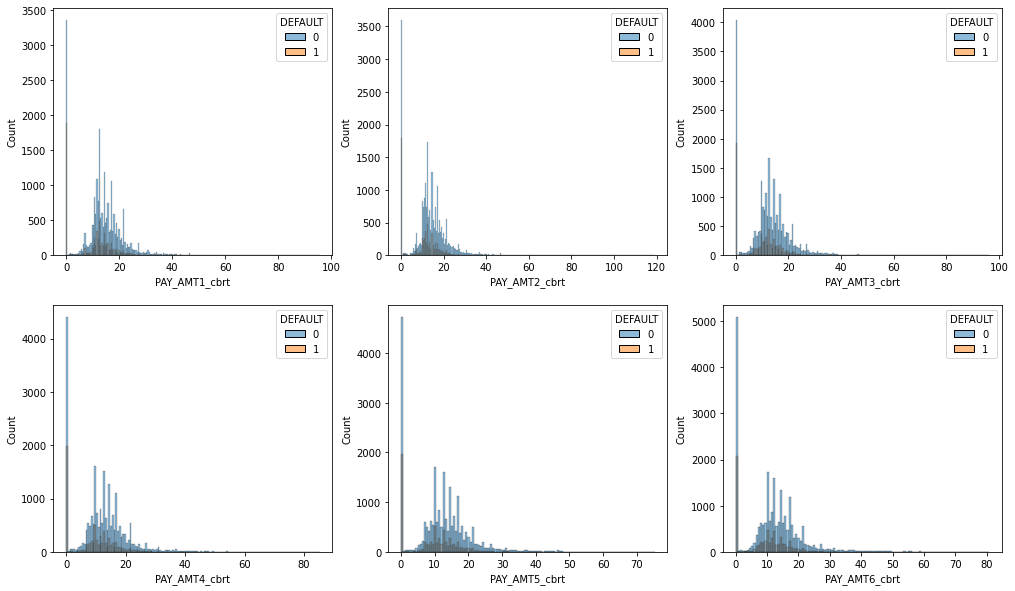

In [50]:
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.histplot(x = "PAY_AMT1_cbrt", hue = "DEFAULT", data = creditCard, ax = ax[0, 0])
sns.histplot(x = "PAY_AMT2_cbrt", hue = "DEFAULT", data = creditCard, ax = ax[0, 1])
sns.histplot(x = "PAY_AMT3_cbrt", hue = "DEFAULT", data = creditCard, ax = ax[0, 2])
sns.histplot(x = "PAY_AMT4_cbrt", hue = "DEFAULT", data = creditCard, ax = ax[1, 0])
sns.histplot(x = "PAY_AMT5_cbrt", hue = "DEFAULT", data = creditCard, ax = ax[1, 1])
sns.histplot(x = "PAY_AMT6_cbrt", hue = "DEFAULT", data = creditCard, ax = ax[1, 2])
plt.show()

In [51]:
### Let's delete the cbrt-transformations of 'PAY_AMT#'

cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
for col in cols:
    name = col + "_cbrt"
    creditCard.drop(name, axis = 1, inplace = True)

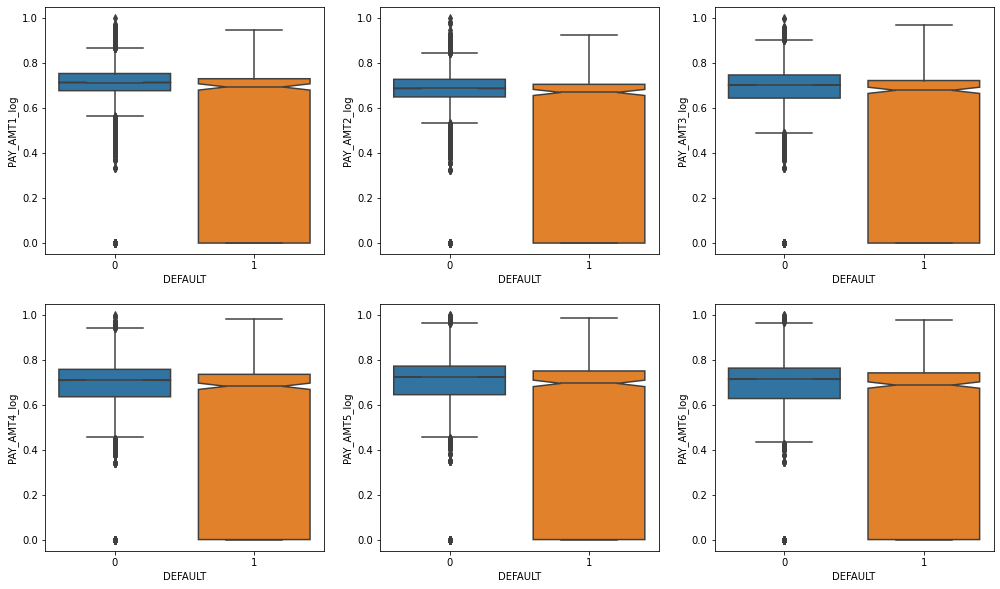

In [52]:
### Let's explore whether 'PAY_AMT#' relates to defaulting

# We extract the relevant columns to scale them so that it's visually easier to see the relationships
cols = ["PAY_AMT1_log", "PAY_AMT2_log", "PAY_AMT3_log", "PAY_AMT4_log", "PAY_AMT5_log", "PAY_AMT6_log"]
creditCard_pay = creditCard[cols].copy()

# We apply the min-max scaler
scaler = preprocessing.MinMaxScaler()
creditCard_pay[cols] = scaler.fit_transform(creditCard_pay[cols])

# We concatenate the scaled features with 'DEFAULT'
creditCard_pay = pd.concat([creditCard_pay, creditCard[["DEFAULT"]]], axis = 1)

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.boxplot(x = "DEFAULT", y = "PAY_AMT1_log", data = creditCard_pay, ax = ax[0, 0], notch = True)
sns.boxplot(x = "DEFAULT", y = "PAY_AMT2_log", data = creditCard_pay, ax = ax[0, 1], notch = True)
sns.boxplot(x = "DEFAULT", y = "PAY_AMT3_log", data = creditCard_pay, ax = ax[0, 2], notch = True)
sns.boxplot(x = "DEFAULT", y = "PAY_AMT4_log", data = creditCard_pay, ax = ax[1, 0], notch = True)
sns.boxplot(x = "DEFAULT", y = "PAY_AMT5_log", data = creditCard_pay, ax = ax[1, 1], notch = True)
sns.boxplot(x = "DEFAULT", y = "PAY_AMT6_log", data = creditCard_pay, ax = ax[1, 2], notch = True)
plt.show()

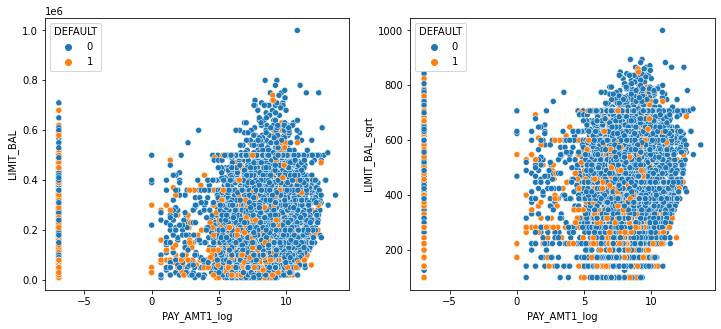

In [53]:
### We could also explore how the payment amounts relate to the credit amount and differentiate defaulters
### from non-defaulters. For illustrative purposes, we only plot the scatterplots for 'PAY_AMT1' 

# Overall, defaulters seem to concentrate more in the lower left (lower credit amounts and lower last payments)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.scatterplot(x = "PAY_AMT1_log", y = "LIMIT_BAL", hue = "DEFAULT", data = creditCard, ax = ax[0])
sns.scatterplot(x = "PAY_AMT1_log", y = "LIMIT_BAL_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[1])
plt.show()

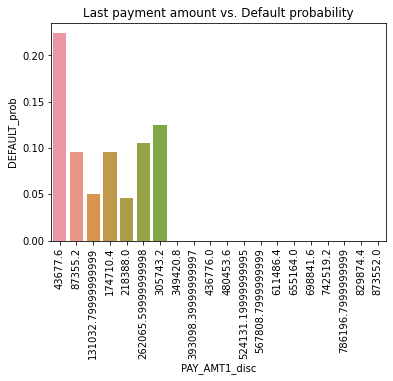

In [54]:
### Let's discretize 'PAY_AMT1' to study the probability of defaulting as the last payment changes

results, bin_edges = pd.cut(creditCard["PAY_AMT1"], bins = np.linspace(creditCard["PAY_AMT1"].min(), \
    creditCard["PAY_AMT1"].max(), 21), retbins = True, include_lowest = True, labels = None)

### This code extracts only the bin edges, which we'll use later as the category labels
bin_edges = pd.cut(creditCard["PAY_AMT1"], bins = np.linspace(creditCard["PAY_AMT1"].min(), \
    creditCard["PAY_AMT1"].max(), 21), retbins = True, include_lowest = True, labels = None)[1]

### We'll assign the labels extracted previously to the results of the discretization. Note that the argument
### 'retbins' is no longer used and the argument 'labels' takes the 'bin_edges' extracted above
results = pd.cut(creditCard["PAY_AMT1"], bins = np.linspace(creditCard["PAY_AMT1"].min(), \
    creditCard["PAY_AMT1"].max(), 21), include_lowest = True, labels = bin_edges.tolist()[1:21])

### We'll convert these results into a DataFrame and append them to the dataset
results = results.to_frame().rename(columns = {"PAY_AMT1": "PAY_AMT1_disc"})
creditCard = pd.concat([creditCard, results], axis = 1)

### Since defaulters have DEFAULT = 1, a simple average over 'DEFAULT' will tell us the average probability of defaulting
pay_amt1_bars = creditCard[["PAY_AMT1_disc", "DEFAULT"]].groupby("PAY_AMT1_disc").mean().reset_index().\
    rename(columns = {"DEFAULT": "DEFAULT_prob"})

### Let's visually check the probability of defaulting as the last payment changes
sns.barplot(x = "PAY_AMT1_disc", y = "DEFAULT_prob", data = pay_amt1_bars)
plt.title("Last payment amount vs. Default probability")
plt.xticks(rotation = 90)
plt.show()

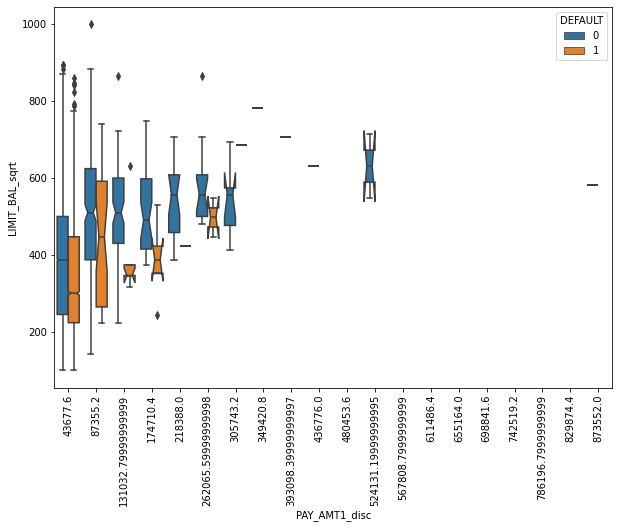

In [55]:
### We could also check how defaulting changes according to the credit amount and each last payment category

# The plot isn't clear-cut, but it seems to suggest defaulters have lower credit amounts overall

plt.figure(figsize = (10, 7))
sns.boxplot(x = "PAY_AMT1_disc", y = "LIMIT_BAL_sqrt", hue = "DEFAULT", data = creditCard, notch = True)
plt.xticks(rotation = 90)
plt.show()

In [56]:
### Let's delete the discretized 'PAY_AMT1'

#creditCard.drop("PAY_AMT1_disc", axis = 1, inplace = True)
#creditCard.head()

In [57]:
### Let's create variables that capture the relationship between bills and payments

creditCard["BALANCE6"] = creditCard["BILL_AMT6"] - creditCard["PAY_AMT5"]
creditCard["BALANCE5"] = creditCard["BILL_AMT5"] - creditCard["PAY_AMT4"]
creditCard["BALANCE4"] = creditCard["BILL_AMT4"] - creditCard["PAY_AMT3"]
creditCard["BALANCE3"] = creditCard["BILL_AMT3"] - creditCard["PAY_AMT2"]
creditCard["BALANCE2"] = creditCard["BILL_AMT2"] - creditCard["PAY_AMT1"]
creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,LIMIT_BAL_disc,BILL_AMT1_cbrt,BILL_AMT2_cbrt,BILL_AMT3_cbrt,BILL_AMT4_cbrt,BILL_AMT5_cbrt,BILL_AMT6_cbrt,BILL_AMT1_disc,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log,PAY_AMT1_disc,BALANCE6,BALANCE5,BALANCE4,BALANCE3,BALANCE2
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,141.421356,59500.0,15.758079,14.584132,8.832285,0.000000,0.000000,0.000000,3933.65,-6.907755,6.535243,-6.907755,-6.907755,-6.907755,-6.907755,43677.6,0.0,0.0,0.0,0.0,3102.0
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,346.410162,158500.0,13.893754,11.993052,13.893754,14.845828,15.117594,14.829173,3933.65,-6.907755,6.907756,6.907756,6.907756,-6.907755,7.600903,43677.6,3261.0,2455.0,2272.0,1682.0,1725.0
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,300.000000,109000.0,30.807338,24.116906,23.845653,24.289887,24.633589,24.959401,60438.20,7.325150,7.313221,6.907756,6.907756,6.907756,8.517193,43677.6,14549.0,13948.0,13331.0,12059.0,12509.0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,223.606798,59500.0,36.085701,36.401121,36.665353,30.478979,30.708683,30.915134,60438.20,7.600903,7.610358,7.090078,7.003066,6.974480,6.907756,43677.6,28478.0,27859.0,27114.0,47272.0,46233.0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,223.606798,59500.0,20.501487,17.831766,32.968749,27.562941,26.752191,26.745203,60438.20,7.600903,10.510014,9.210340,9.104980,6.535243,6.520623,43677.6,18442.0,10146.0,10940.0,-846.0,3670.0


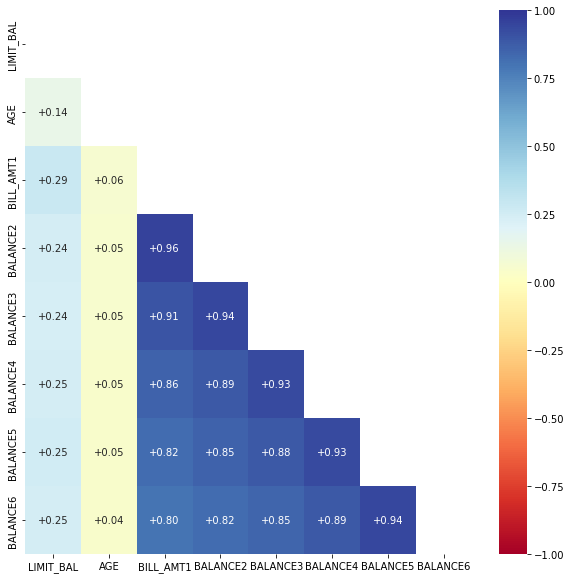

In [58]:
### Let's check the correlations again

creditCardCorrM = creditCard[["LIMIT_BAL", "AGE", "BILL_AMT1", "BALANCE2", "BALANCE3", "BALANCE4", "BALANCE5", \
    "BALANCE6"]].corr()

# Mask the upper half for visualization purposes
mask = np.zeros_like(creditCardCorrM, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (10, 10))
sns.heatmap(creditCardCorrM, mask = mask, cmap = "RdYlBu",
            vmin = -1, vmax = 1, annot = True,
            fmt = "+.2f")
plt.show()

In [59]:
### Let's delete the 'BALANCE' variables

cols = ["BALANCE2", "BALANCE3", "BALANCE4", "BALANCE5", "BALANCE6"]
creditCard.drop(cols, axis = 1, inplace = True)
creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,LIMIT_BAL_disc,BILL_AMT1_cbrt,BILL_AMT2_cbrt,BILL_AMT3_cbrt,BILL_AMT4_cbrt,BILL_AMT5_cbrt,BILL_AMT6_cbrt,BILL_AMT1_disc,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log,PAY_AMT1_disc
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,141.421356,59500.0,15.758079,14.584132,8.832285,0.000000,0.000000,0.000000,3933.65,-6.907755,6.535243,-6.907755,-6.907755,-6.907755,-6.907755,43677.6
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,346.410162,158500.0,13.893754,11.993052,13.893754,14.845828,15.117594,14.829173,3933.65,-6.907755,6.907756,6.907756,6.907756,-6.907755,7.600903,43677.6
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,300.000000,109000.0,30.807338,24.116906,23.845653,24.289887,24.633589,24.959401,60438.20,7.325150,7.313221,6.907756,6.907756,6.907756,8.517193,43677.6
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,223.606798,59500.0,36.085701,36.401121,36.665353,30.478979,30.708683,30.915134,60438.20,7.600903,7.610358,7.090078,7.003066,6.974480,6.907756,43677.6
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,223.606798,59500.0,20.501487,17.831766,32.968749,27.562941,26.752191,26.745203,60438.20,7.600903,10.510014,9.210340,9.104980,6.535243,6.520623,43677.6


## `PAY_#`

These categorical variables capture the payment statuses. They're available for six months, where `PAY_1` captures the payment status in Sep, `PAY_2` captures the payment status in Aug, and so on up to `PAY_6` (Apr). Note that `PAY_1` is `PAY_0` in the original dataset. I use `PAY_1` to keep consistency with the naming convention of `BILL_AMT#` and `PAY_AMT#`.

Barplots of default probability contrasting the payment statuses suggest these statuses might be important features to understand defaulting, where defaulting increases when there're payment delays. However, note a 1-month delay has contrasting effects according to what month we look at.

In [60]:
##################################################
### PAY_1: repayment status in September 2005
##################################################

pay1_bars = creditCard[["PAY_1", "DEFAULT"]].groupby("PAY_1").mean().reset_index().\
    rename(columns = {"DEFAULT": "DEFAULT_prob"})

In [61]:
### What does PAY_1 = -2 mean? This category isn't mentioned in kaggle. The count (2,759) is high
### What does PAY_1 = 0 mean? This category isn't mentioned in kaggle. It has the highest count (14,737)

creditCard["PAY_1"].value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_1, dtype: int64

In [62]:
### According to a discussion in kaggle, -2 and 0 could be treated the same way. They mean no payment balance
    # https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/71771

### However, another discussion suggests they capture something different:
    ### -2 means there's no credit to pay
    ### 0 means there was an on time payment, but lower than the bill (perhaps a minimum payment)
        # https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/157664

### Another discussion supports the last point:
    ### -2 means no consumption
    ### 0 means paid the minimum due amount
    ### -1 means paid in full, but there's a balance at the end of the period due to recent transactions
        # https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608

### To clarify this discussion, it may be worthwhile to note that BILL_AMT(t) is paid with PAY_AMT(t-1). Don't let get
### confused by 't': Sep is t = 1, Aug is t = 2, and so on, so month(t - 1) is a future month compared to month(t). For
### example:
    ### Aug bill (BILL_AMT2) is paid with Sep payment (PAY_AMT1)
    ### Jul bill (BILL_AMT3) is paid with Aug payment (PAY-AMT2), and so on

### However, looking at some rows, the discussion isn't clear-cut.
### For example, ID = 24 has no consumption, but some bills are positive. 'BILL_AMT4' is positive (560), it seems it's paid
### in full (PAY_AMT3 = 560) and remaining bills are positive even when 'PAY_#' indicates no consumption

creditCard[creditCard["PAY_2"] == -2].head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,LIMIT_BAL_disc,BILL_AMT1_cbrt,BILL_AMT2_cbrt,BILL_AMT3_cbrt,BILL_AMT4_cbrt,BILL_AMT5_cbrt,BILL_AMT6_cbrt,BILL_AMT1_disc,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log,PAY_AMT1_disc
9,10,20000.0,1,3,2,35,-2,-2,-2,-2,-1,-1,0.0,0.0,0.0,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0,0,141.421356,59500.0,0.000000,0.000000,0.000000,0.000000,23.517566,24.050818,3933.65,-6.907755,-6.907755,-6.907755,9.473243,7.022869,-6.907755,43677.6
18,19,360000.0,2,1,1,49,1,-2,-2,-2,-2,-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,600.000000,406000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3933.65,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,43677.6
19,20,180000.0,2,1,2,29,1,-2,-2,-2,-2,-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,424.264069,208000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3933.65,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,43677.6
23,24,450000.0,2,1,1,40,-2,-2,-2,-2,-2,-2,5512.0,19420.0,1473.0,560.0,0.0,0.0,19428.0,1473.0,560.0,0.0,0.0,1128.0,1,670.820393,455500.0,17.664570,26.879204,11.378043,8.242571,0.000000,0.000000,60438.20,9.874471,7.295057,6.327939,-6.907755,-6.907755,7.028202,43677.6
26,27,60000.0,1,1,2,27,1,-2,-1,-1,-1,-1,-109.0,-425.0,259.0,-57.0,127.0,-189.0,0.0,1000.0,0.0,500.0,0.0,1000.0,1,244.948974,109000.0,-4.776856,-7.518473,6.374311,-3.848501,5.026526,-5.738794,3933.65,-6.907755,6.907756,-6.907755,6.214610,-6.907755,6.907756,43677.6
33,34,500000.0,2,2,1,54,-2,-2,-2,-2,-2,-2,10929.0,4152.0,22722.0,7521.0,71439.0,8981.0,4152.0,22827.0,7521.0,71439.0,981.0,51582.0,0,707.106781,505000.0,22.191848,16.072587,28.323626,19.592591,41.493346,20.786190,60438.20,8.331346,10.035699,8.925455,11.176599,6.888573,10.850928,43677.6
34,35,500000.0,1,1,1,58,-2,-2,-2,-2,-2,-2,13709.0,5006.0,31130.0,3180.0,0.0,5293.0,5006.0,31178.0,3180.0,0.0,5293.0,768.0,0,707.106781,505000.0,23.933264,17.106597,31.457657,14.705362,0.000000,17.427455,60438.20,8.518393,10.347468,8.064637,-6.907755,8.574141,6.643791,43677.6
45,46,210000.0,1,1,2,29,-2,-2,-2,-2,-2,-2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,458.257569,257500.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3933.65,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,43677.6
52,53,310000.0,2,2,1,49,-2,-2,-2,-2,-2,-2,13465.0,7867.0,7600.0,11185.0,3544.0,464.0,7875.0,7600.0,11185.0,3544.0,464.0,0.0,0,556.776436,356500.0,23.790421,19.888547,19.660951,22.363786,15.246304,7.741753,60438.20,8.971449,8.935904,9.322329,8.173012,6.139887,-6.907755,43677.6
55,56,500000.0,2,1,1,45,-2,-2,-2,-2,-2,-2,1905.0,3640.0,162.0,0.0,151.0,2530.0,3640.0,162.0,0.0,151.0,2530.0,0.0,0,707.106781,505000.0,12.396478,15.382743,5.451362,0.000000,5.325074,13.626161,3933.65,8.199739,5.087603,-6.907755,5.017286,7.835975,-6.907755,43677.6


In [63]:
### Let's check ID = 5.
    ### 'PAY_3' indicates paid in full (-1), 'BILL_AMT3' is 35,835 and 'PAY_AMT2' is 36,681.
    ### Then, 'PAY_2' indicates minimum payment (0), 'BILL_AMT2' is 5,670 and 'PAY_AMT1' is 2,000.

creditCard[creditCard["PAY_2"] == 0].head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,LIMIT_BAL_disc,BILL_AMT1_cbrt,BILL_AMT2_cbrt,BILL_AMT3_cbrt,BILL_AMT4_cbrt,BILL_AMT5_cbrt,BILL_AMT6_cbrt,BILL_AMT1_disc,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log,PAY_AMT1_disc
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,300.000000,109000.0,30.807338,24.116906,23.845653,24.289887,24.633589,24.959401,60438.20,7.325150,7.313221,6.907756,6.907756,6.907756,8.517193,43677.6
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,223.606798,59500.0,36.085701,36.401121,36.665353,30.478979,30.708683,30.915134,60438.20,7.600903,7.610358,7.090078,7.003066,6.974480,6.907756,43677.6
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,223.606798,59500.0,20.501487,17.831766,32.968749,27.562941,26.752191,26.745203,60438.20,7.600903,10.510014,9.210340,9.104980,6.535243,6.520623,43677.6
5,6,50000.0,1,1,2,37,0,0,0,0,0,0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0,223.606798,59500.0,40.083160,38.500534,38.621363,26.867203,26.970704,27.155029,116942.75,7.824046,7.503841,6.487686,6.907756,6.907756,6.684613,43677.6
6,7,500000.0,1,1,2,29,0,0,0,0,0,0,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0,707.106781,505000.0,71.658685,74.411573,76.346468,81.565669,78.460296,77.966674,399465.50,10.915088,10.596635,10.545341,9.915367,9.528794,9.530248,87355.2
8,9,140000.0,2,3,1,28,0,0,2,0,0,0,11285.0,14096.0,12108.0,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0,374.165739,158500.0,22.430237,24.156386,22.962763,23.027692,22.761878,15.493233,60438.20,8.110428,-6.907755,6.068428,6.907756,6.907756,6.907756,43677.6
10,11,200000.0,2,3,2,34,0,0,2,0,0,-1,11073.0,9787.0,5535.0,2513.0,1828.0,3731.0,2306.0,12.0,50.0,300.0,3738.0,66.0,0,447.213595,208000.0,22.288890,21.390283,17.689106,13.595572,12.227154,15.509879,60438.20,7.743270,2.484990,3.912043,5.703786,8.226306,4.189670,43677.6
12,13,630000.0,2,2,2,41,-1,0,-1,-1,-1,-1,12137.0,6500.0,6500.0,6500.0,6500.0,2870.0,1000.0,6500.0,6500.0,6500.0,2870.0,0.0,0,793.725393,653500.0,22.981081,18.662556,18.662556,18.662556,18.662556,14.211087,60438.20,6.907756,8.779558,8.779558,8.779558,7.962068,-6.907755,43677.6
14,15,250000.0,1,1,2,29,0,0,0,0,0,0,70887.0,67060.0,63561.0,59696.0,56875.0,55512.0,3000.0,3000.0,3000.0,3000.0,3000.0,3000.0,0,500.000000,257500.0,41.386198,40.627601,39.908332,39.082447,38.456858,38.147167,116942.75,8.006368,8.006368,8.006368,8.006368,8.006368,8.006368,43677.6
16,17,20000.0,1,1,2,24,0,0,2,2,2,2,15376.0,18010.0,17428.0,18338.0,17905.0,19104.0,3200.0,0.0,1500.0,0.0,1650.0,0.0,1,141.421356,59500.0,24.866488,26.212266,25.926816,26.370437,26.161227,26.732615,60438.20,8.070906,-6.907755,7.313221,-6.907755,7.408531,-6.907755,43677.6


In [64]:
### Let's check ID = 8
    ### 'PAY_3' indicates paid in full (-1), 'BILL_AMT3' is 601 and 'PAY_AMT2' is 601.
    ### Then, 'PAY_2' indicates paid in full (-1), 'BILL_AMT2' is 380 and 'PAY_AMT1' is 380.

### Let's check ID = 40
    ### 'PAY_6' indicates paid in full (-1), 'BILL_AMT6' is 9,477 and 'PAY_AMT5' is 9,525.
    ### Then, 'PAY_5' indicates minimum payment (0), 'BILL_AMT5' is 17,976 and 'PAY_AMT4' is 8,000.
    ### Then, 'PAY_4' indicates paid in full (-1), 'BILL_AMT4' is 9,976 and 'PAY_AMT3' is 9,976.
    ### Then, 'PAY_3' indicates 2-month payment delay (2), 'BILL_AMT3' is 4,641 and 'PAY_AMT2' is 0.
        ### Shouldn't be the case that PAY_3 = 1?
    ### Then, 'PAY_2' indicates paid in full (-1), 'BILL_AMT2' is 9,075 and 'PAY_AMT1' is 9,075.

creditCard[creditCard["PAY_2"] == -1].head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,LIMIT_BAL_disc,BILL_AMT1_cbrt,BILL_AMT2_cbrt,BILL_AMT3_cbrt,BILL_AMT4_cbrt,BILL_AMT5_cbrt,BILL_AMT6_cbrt,BILL_AMT1_disc,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log,PAY_AMT1_disc
7,8,100000.0,2,2,2,23,0,-1,-1,0,0,-1,11876.0,380.0,601.0,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0,316.227766,109000.0,22.815154,7.243156,8.439010,6.045944,-5.417502,8.276773,60438.20,5.940174,6.398597,-6.907755,6.364752,7.430708,7.340836,43677.6
11,12,260000.0,2,1,2,51,-1,-1,-1,-1,-1,2,12261.0,21670.0,9966.0,8517.0,22287.0,13668.0,21818.0,9966.0,8583.0,22301.0,0.0,3640.0,0,509.901951,307000.0,23.059079,27.879585,21.519902,20.421872,28.141714,23.909380,60438.20,9.990491,9.206935,9.057539,10.012387,-6.907755,8.199739,43677.6
21,22,120000.0,2,2,1,39,-1,-1,-1,-1,-1,-1,316.0,316.0,316.0,0.0,632.0,316.0,316.0,316.0,0.0,632.0,316.0,0.0,1,346.410162,158500.0,6.811285,6.811285,6.811285,0.000000,8.581681,6.811285,3933.65,5.755745,5.755745,-6.907755,6.448891,5.755745,-6.907755,43677.6
28,29,50000.0,2,3,1,47,-1,-1,-1,-1,-1,-1,650.0,3415.0,3416.0,2040.0,30430.0,257.0,3415.0,3421.0,2044.0,30430.0,257.0,0.0,0,223.606798,59500.0,8.662391,15.059027,15.060496,12.682651,31.220078,6.357861,3933.65,8.135933,8.137688,7.622664,10.323184,5.549080,-6.907755,43677.6
30,31,230000.0,2,1,2,27,-1,-1,-1,-1,-1,-1,16646.0,17265.0,13266.0,15339.0,14307.0,36923.0,17270.0,13281.0,15339.0,14307.0,37292.0,0.0,0,479.583152,257500.0,25.533085,25.845733,23.672638,24.846526,24.276320,33.299087,60438.20,9.756726,9.494090,9.638154,9.568504,10.526534,-6.907755,43677.6
35,36,160000.0,1,1,2,30,-1,-1,-2,-2,-2,-1,30265.0,-131.0,-527.0,-923.0,-1488.0,-1884.0,131.0,396.0,396.0,565.0,792.0,0.0,0,400.000000,208000.0,31.163548,-5.078753,-8.077374,-9.736448,-11.416535,-12.350759,60438.20,4.875205,5.981417,5.981417,6.336828,6.674563,-6.907755,43677.6
38,39,50000.0,1,1,2,25,1,-1,-1,-2,-2,-2,0.0,780.0,0.0,0.0,0.0,0.0,780.0,0.0,0.0,0.0,0.0,0.0,1,223.606798,59500.0,0.000000,9.205164,0.000000,0.000000,0.000000,0.000000,3933.65,6.659295,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,43677.6
39,40,280000.0,1,1,2,31,-1,-1,2,-1,0,-1,498.0,9075.0,4641.0,9976.0,17976.0,9477.0,9075.0,0.0,9976.0,8000.0,9525.0,781.0,0,529.150262,307000.0,7.926408,20.858459,16.680300,21.527098,26.195761,21.162012,3933.65,9.113279,-6.907755,9.207938,8.987197,9.161675,6.660576,43677.6
48,49,380000.0,1,2,2,32,-1,-1,-1,-1,-1,-1,22401.0,21540.0,15134.0,32018.0,11849.0,11873.0,21540.0,15138.0,24677.0,11851.0,11875.0,8251.0,0,616.441400,406000.0,28.189614,27.823722,24.735341,31.753973,22.797850,22.813232,60438.20,9.977667,9.624963,10.113627,9.380168,9.382191,9.018090,43677.6
64,65,130000.0,2,2,1,51,-1,-1,-2,-2,-1,-1,99.0,0.0,0.0,0.0,2353.0,0.0,0.0,0.0,0.0,2353.0,0.0,0.0,0,360.555128,158500.0,4.626065,0.000000,0.000000,0.000000,13.300684,0.000000,3933.65,-6.907755,-6.907755,-6.907755,7.763447,-6.907755,-6.907755,43677.6


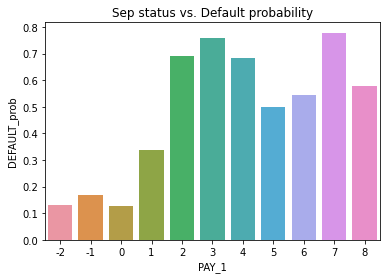

In [65]:
sns.barplot(x = "PAY_1", y = "DEFAULT_prob", data = pay1_bars)
plt.title("Sep status vs. Default probability")
plt.show()

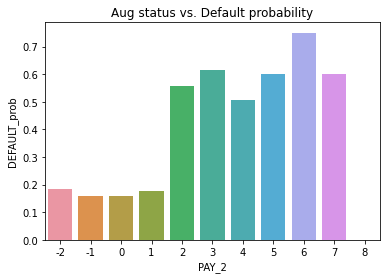

In [66]:
##################################################
### PAY_2: repayment status in August 2005
##################################################

pay2_bars = creditCard[["PAY_2", "DEFAULT"]].groupby("PAY_2").mean().reset_index().\
    rename(columns = {"DEFAULT": "DEFAULT_prob"})
sns.barplot(x = "PAY_2", y = "DEFAULT_prob", data = pay2_bars)
plt.title("Aug status vs. Default probability")
plt.show()

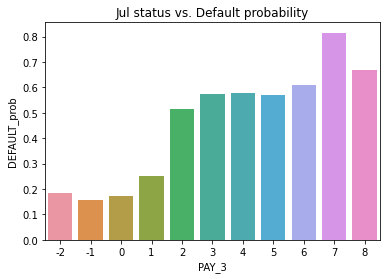

In [67]:
##################################################
### PAY_3: repayment status in July 2005
##################################################

pay3_bars = creditCard[["PAY_3", "DEFAULT"]].groupby("PAY_3").mean().reset_index().\
    rename(columns = {"DEFAULT": "DEFAULT_prob"})
sns.barplot(x = "PAY_3", y = "DEFAULT_prob", data = pay3_bars)
plt.title("Jul status vs. Default probability")
plt.show()

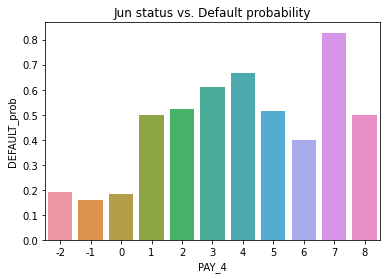

In [68]:
##################################################
### PAY_4: repayment status in June 2005
##################################################

pay4_bars = creditCard[["PAY_4", "DEFAULT"]].groupby("PAY_4").mean().reset_index().\
    rename(columns = {"DEFAULT": "DEFAULT_prob"})
sns.barplot(x = "PAY_4", y = "DEFAULT_prob", data = pay4_bars)
plt.title("Jun status vs. Default probability")
plt.show()

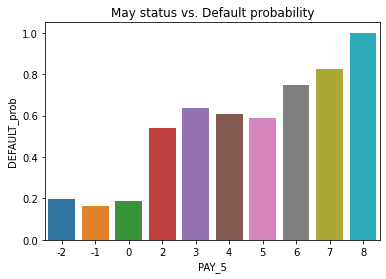

In [69]:
##################################################
### PAY_5: repayment status in May 2005
##################################################

pay5_bars = creditCard[["PAY_5", "DEFAULT"]].groupby("PAY_5").mean().reset_index().\
    rename(columns = {"DEFAULT": "DEFAULT_prob"})
sns.barplot(x = "PAY_5", y = "DEFAULT_prob", data = pay5_bars)
plt.title("May status vs. Default probability")
plt.show()

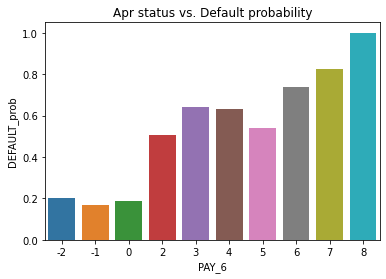

In [70]:
##################################################
### PAY_6: repayment status in April 2005
##################################################

pay6_bars = creditCard[["PAY_6", "DEFAULT"]].groupby("PAY_6").mean().reset_index().\
    rename(columns = {"DEFAULT": "DEFAULT_prob"})
sns.barplot(x = "PAY_6", y = "DEFAULT_prob", data = pay6_bars)
plt.title("Apr status vs. Default probability")
plt.show()

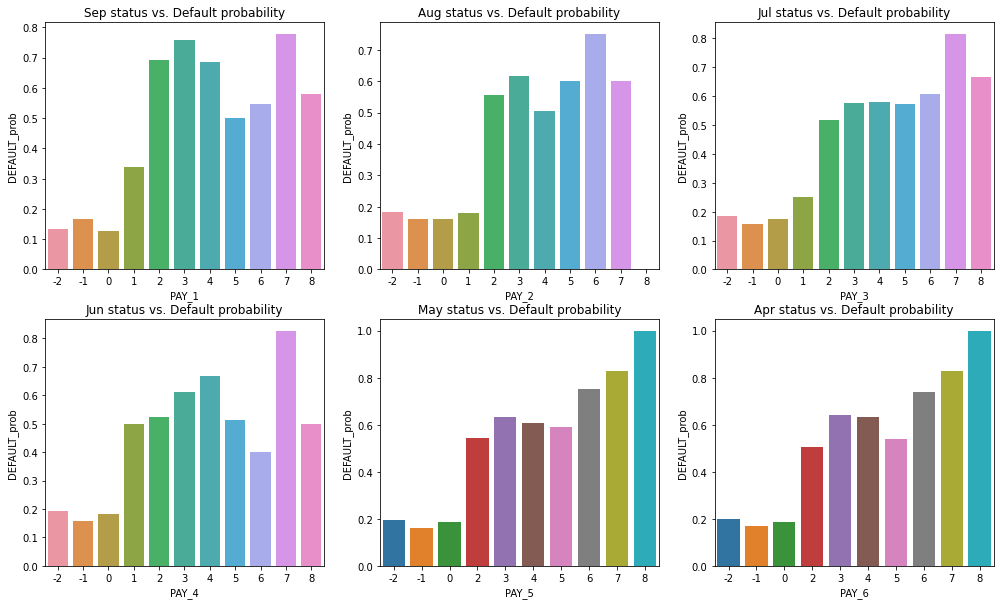

In [71]:
### Let's bring all 'PAY_#' together

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (17, 10))
sns.barplot(x = "PAY_1", y = "DEFAULT_prob", data = pay1_bars, ax = ax[0, 0])
ax[0, 0].set_title("Sep status vs. Default probability")
sns.barplot(x = "PAY_2", y = "DEFAULT_prob", data = pay2_bars, ax = ax[0, 1])
ax[0, 1].set_title("Aug status vs. Default probability")
sns.barplot(x = "PAY_3", y = "DEFAULT_prob", data = pay3_bars, ax = ax[0, 2])
ax[0, 2].set_title("Jul status vs. Default probability")
sns.barplot(x = "PAY_4", y = "DEFAULT_prob", data = pay4_bars, ax = ax[1, 0])
ax[1, 0].set_title("Jun status vs. Default probability")
sns.barplot(x = "PAY_5", y = "DEFAULT_prob", data = pay5_bars, ax = ax[1, 1])
ax[1, 1].set_title("May status vs. Default probability")
sns.barplot(x = "PAY_6", y = "DEFAULT_prob", data = pay6_bars, ax = ax[1, 2])
ax[1, 2].set_title("Apr status vs. Default probability")
plt.show()

## `AGE`

This continuous variable captures the age of the credit holder. Its histogram shows a somewhat non-normal behavior (right-skewed). A visual inspection of the transformations suggests neither of the them are successful.

A boxplot of `AGE` contrasting defaulters and non-defaulters suggests the credit holder's age might not be an important feature to understand defaulting.

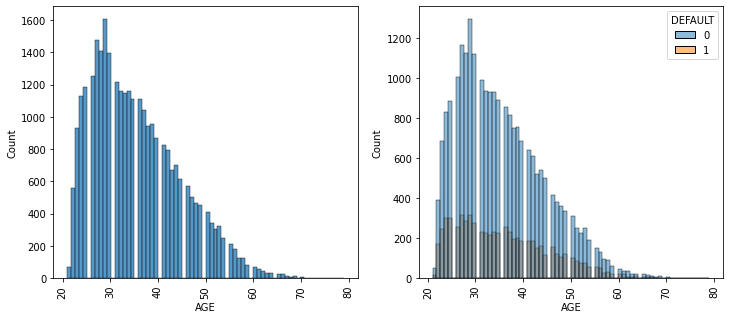

In [72]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.histplot(x = "AGE", data = creditCard, ax = ax[0])
ax[0].tick_params(axis = 'x', rotation = 90)
    # https://stackoverflow.com/questions/31186019/rotate-tick-labels-in-subplot-pyplot-matplotlib-gridspec
sns.histplot(x = "AGE", hue = "DEFAULT", data = creditCard, ax = ax[1])
ax[1].tick_params(axis = 'x', rotation = 90)
plt.show()

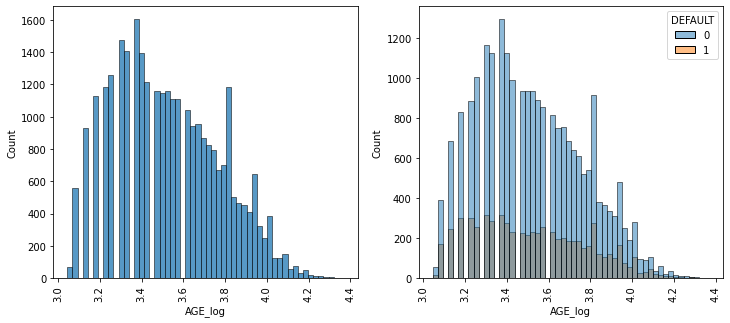

In [73]:
### Let's try a log-transformation of 'AGE'

creditCard["AGE_log"] = np.log(creditCard["AGE"])

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.histplot(x = "AGE_log", data = creditCard, ax = ax[0])
ax[0].tick_params(axis = 'x', rotation = 90)
sns.histplot(x = "AGE_log", hue = "DEFAULT", data = creditCard, ax = ax[1])
ax[1].tick_params(axis = 'x', rotation = 90)
plt.show()

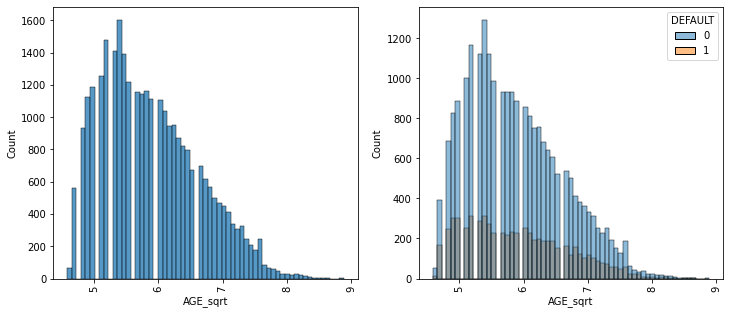

In [74]:
### Let's try a square root transformation of 'AGE'

creditCard["AGE_sqrt"] = np.sqrt(creditCard["AGE"])  

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.histplot(x = "AGE_sqrt", data = creditCard, ax = ax[0])
ax[0].tick_params(axis = 'x', rotation = 90)
sns.histplot(x = "AGE_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[1])
ax[1].tick_params(axis = 'x', rotation = 90)
plt.show()

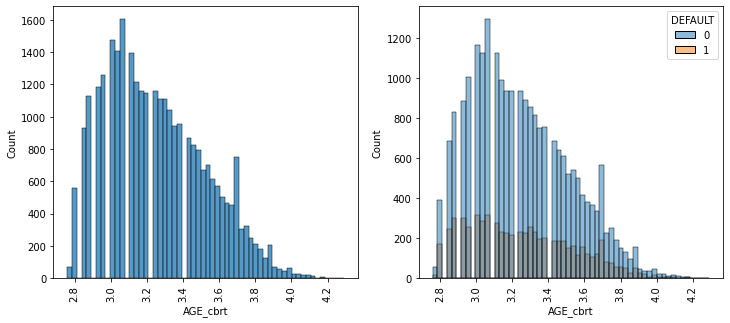

In [75]:
### Let's try a cubic root transformation of 'AGE'

creditCard["AGE_cbrt"] = np.cbrt(creditCard["AGE"])  

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.histplot(x = "AGE_cbrt", data = creditCard, ax = ax[0])
ax[0].tick_params(axis = 'x', rotation = 90)
sns.histplot(x = "AGE_cbrt", hue = "DEFAULT", data = creditCard, ax = ax[1])
ax[1].tick_params(axis = 'x', rotation = 90)
plt.show()

In [76]:
### Let's delete the transformations of 'AGE'

creditCard.drop("AGE_log", axis = 1, inplace = True)
creditCard.drop("AGE_sqrt", axis = 1, inplace = True)
creditCard.drop("AGE_cbrt", axis = 1, inplace = True)

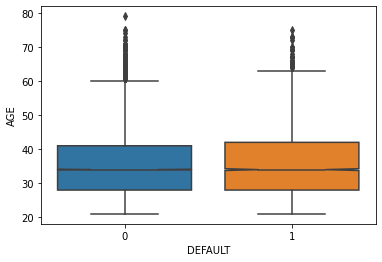

In [77]:
### Let's explore whether 'AGE' relates to defaulting

sns.boxplot(x = "DEFAULT", y = "AGE", data = creditCard, notch = True)
plt.show()

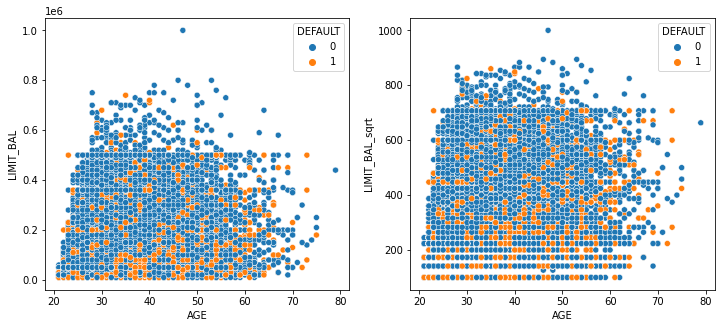

In [78]:
### We could also explore how age correlates with the credit amount and differentiate defaulters from non-defaulters

# Overall, defaulters seem to concentrate more in the lower half (lower credit amounts) and perhaps less in the right
# (increasing age)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.scatterplot(x = "AGE", y = "LIMIT_BAL", hue = "DEFAULT", data = creditCard, ax = ax[0])
sns.scatterplot(x = "AGE", y = "LIMIT_BAL_sqrt", hue = "DEFAULT", data = creditCard, ax = ax[1])
plt.show()

## `SEX`

This categorical variable captures the reported gender of the credit holder. A barplot of default probability contrasting males and females and a boxplot of the credit amount contrasting males and females suggest the credit holder's gender might be a somewhat important feature to understand defaulting, where males seem to default more.

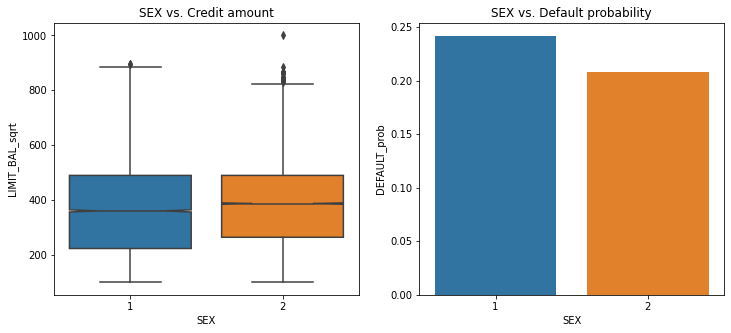

In [79]:
sex_bars = creditCard[["SEX", "DEFAULT"]].groupby("SEX").mean().reset_index().\
    rename(columns = {"DEFAULT": "DEFAULT_prob"})
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.boxplot(x = "SEX", y = "LIMIT_BAL_sqrt", data = creditCard, ax = ax[0], notch = True)
ax[0].set_title("SEX vs. Credit amount")
sns.barplot(x = "SEX", y = "DEFAULT_prob", data = sex_bars, ax = ax[1])
ax[1].set_title("SEX vs. Default probability")
plt.show()

## `EDUCATION`

This categorical variable captures the education level of the credit holder. A barplot of default probability contrasting the education levels and a boxplot of the credit amount contrasting the education levels suggest the credit holder's education level might be an important feature to understand defaulting, where people with graduate education and other/unknown education levels seem to default less.

In [80]:
ed_bars = creditCard[["EDUCATION", "DEFAULT"]].groupby("EDUCATION").mean().reset_index().\
    rename(columns = {"DEFAULT": "DEFAULT_prob"})
ed_bars

,EDUCATION,DEFAULT_prob
0,0,0.000000
1,1,0.192348
2,2,0.237349
3,3,0.251576
4,4,0.056911
5,5,0.064286
6,6,0.156863


In [81]:
### What does EDUCATION = 0 mean? This category isn't mentioned in kaggle. The count (14) is small though

    # https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608
    # 0, 4, 5, 6 = others

creditCard["EDUCATION"].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

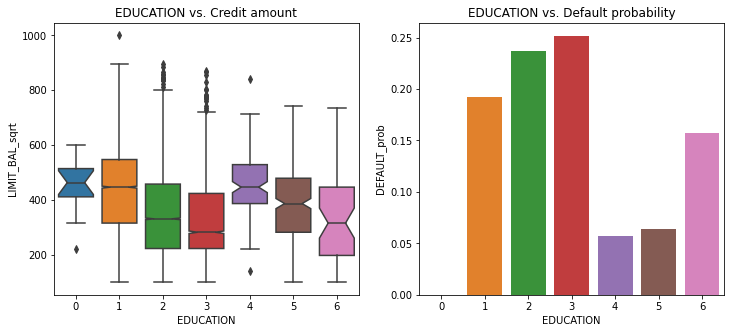

In [82]:
### Let's explore whether 'EDUCATION' relates to defaulting

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.boxplot(x = "EDUCATION", y = "LIMIT_BAL_sqrt", data = creditCard, ax = ax[0], notch = True)
ax[0].set_title("EDUCATION vs. Credit amount")
sns.barplot(x = "EDUCATION", y = "DEFAULT_prob", data = ed_bars, ax = ax[1])
ax[1].set_title("EDUCATION vs. Default probability")
plt.show()

## `MARRIAGE`

This categorical variable captures the marital status of the credit holder. A barplot of default probability contrasting the marital statuses and a boxplot of the credit amount contrasting the marital statuses suggest the credit holder's marital status might be an important feature to understand defaulting, where some statuses (single and other) seem to default less. 

In [83]:
mar_bars = creditCard[["MARRIAGE", "DEFAULT"]].groupby("MARRIAGE").mean().reset_index().\
    rename(columns = {"DEFAULT": "DEFAULT_prob"})
mar_bars

,MARRIAGE,DEFAULT_prob
0,0,0.092593
1,1,0.234717
2,2,0.209283
3,3,0.260062


In [84]:
### What does MARRIAGE = 0 mean? This category isn't mentioned in kaggle. The count (54) is small though

    # https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/discussion/34608
    # 0 = others

creditCard["MARRIAGE"].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

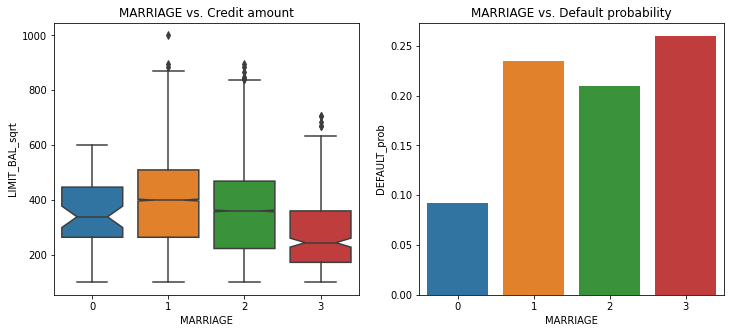

In [85]:
### Let's explore whether 'MARRIAGE' relates to defaulting

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
sns.boxplot(x = "MARRIAGE", y = "LIMIT_BAL_sqrt", data = creditCard, ax = ax[0], notch = True)
ax[0].set_title("MARRIAGE vs. Credit amount")
sns.barplot(x = "MARRIAGE", y = "DEFAULT_prob", data = mar_bars, ax = ax[1])
ax[1].set_title("MARRIAGE vs. Default probability")
plt.show()